# **Import Libraries**

In [1]:
from urllib import request
import nltk
import random
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
from textblob import TextBlob
import wordcloud
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import numpy as np
from scipy.optimize import linear_sum_assignment
from collections import Counter
from sklearn.metrics import silhouette_score
from sklearn.metrics import cohen_kappa_score
from gensim.models.coherencemodel import CoherenceModel
from pprint import pprint
%matplotlib inline
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt')

#!pip install pyLDAvis==2.1.2
#import pyLDAvis.gensim
#pyLDAvis.enable_notebook()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **Get the raw text, partition it, label it**

## **Function to get the raw text from a Gutenberg book url**

In [2]:
def get_raw(url):
  response = request.urlopen(url) # open a connection to the specified url and get the server's response to the HTTP request
  raw = response.read().decode('utf-8-sig') # read the content of the HTTP response as a sequence of bytes and then decode these bytes into a Unicode string using the UTF-8 encoding. The result is the text content of the specified url.
  return raw

## **Function to get the part of the raw text between the end of the author name and the begining of the closing statement**

All Gutenberg books start with the opening statement  "START OF THE PROJECT GUTENBERG EBOOK" followed by the title and author name, and end with the closing statement "END OF THE PROJECT GUTENBERG EBOOK". To do any NLP effectively, we should extract partitions from the raw text that lies between the end of the author name and the begining of the closing statement.

In [3]:
def get_raw_from_author_to_closing(title,author,url):
  raw= get_raw(url)
  opening_statement= '.*start.*ebook.*\n' # lowercase since we will do the search with the lowercase version of the raw text to guarantee a match object
  closing_statement= '.*end.*ebook.*\n'  # lowercase since we will do the search with the lowercase version of the raw text to guarantee a match object

  start_position= re.search(opening_statement,raw.lower()).end() # start position is the end position of the opening statement
  if re.search(title.lower(),raw[start_position:].lower()): # if opening statement is followed by title
    start_position += re.search(title.lower(),raw[start_position:].lower()).end() # update start position to be end of title
    if re.search((author).lower(),raw[start_position:].lower()): # if title is followed by author name
      start_position += re.search((author).lower(),raw[start_position:].lower()).end() #update start position to be end of author name

  end_position= re.search(closing_statement,raw.lower()).start() # end position is the start position of the closing statement
  return raw[start_position:end_position]

## **Function to break down the raw text into a list of tokens i.e. words**

In [4]:
def get_tokens(raw):
  words= nltk.word_tokenize(raw)
  return words

## **Function to extract a specified number of random partitions from a book where each partition contains a specified number of words**

In [5]:
def extract_partitions(title,author,url,num_partitions,num_words_per_partition):
  raw= get_raw_from_author_to_closing(title,author,url) # get raw text from url
  words= get_tokens(raw) # get list of words/tokens from raw text
  partitions= []
  for i in range(num_partitions):
    start_index = random.randint(0, len(words) - num_words_per_partition) # generates a random starting index within the range of valid indices for the words list i.e. in such a way that the selected partition will not go beyond the end of the list
    partition = ' '.join(words[start_index:start_index + num_words_per_partition]) # Extracts a consecutive sequence of num_words_per_partition words starting from a the random position start_index and extending up to start_index + num_words_per_partition and joins the selected words into a single string by using space ' ' as a separator to form a sentence-like structure
    partitions.append(partition) # saves the partition in the list of partitions
  return partitions

## **Function to extract partitions from multiple books and label them as per the book they belong to**

In [6]:
def extract_from_multiple_books(books_details,num_partitions,num_words_per_partition):
  dict={'Partition':[],'Label':[], 'Book Title':[], 'Book Author':[]} # will be used to save each partition with its label and the title and author it belongs to
  for i in range(len(books_details)):
    partitions= extract_partitions(books_details[i]['title'],books_details[i]['author'],books_details[i]['url'],num_partitions,num_words_per_partition)
    for partition in partitions:
      dict['Partition'].append(partition)
      dict['Label'].append(books_details[i]['label'])
      dict['Book Title'].append(books_details[i]['title'])
      dict['Book Author'].append(books_details[i]['author'])
  return dict

## **Function to extract partitions from multiple books and save them in a dataframe and csv file**

In [7]:
def extract_and_save(books_details,num_partitions,num_words_per_partition):
  dict= extract_from_multiple_books(books_details,num_partitions,num_words_per_partition)

  # Assign series for partitions, labels, titles, and authors
  partitions= pd.Series(dict['Partition'])
  labels= pd.Series(dict['Label'])
  titles= pd.Series(dict['Book Title'])
  authors= pd.Series(dict['Book Author'])

  # Construct a data frame from the above series
  data= pd.DataFrame({'Book Title':titles, 'Book Author':authors, 'Label':labels, 'Partition':partitions })

  # Save the data to a csv file
  data.to_csv('sample_partitions.csv', index=False, encoding= 'utf-8-sig')
  return data

## **Extraction of 200 random partitions of 150 words each from 6 books from Gutenberg's Digital Collection belonging to the  Harvard Classics Genre**

In [8]:
# Book 1 Details
url1 = 'https://www.gutenberg.org/cache/epub/4081/pg4081.txt'
title1= 'The Alchemist'
author1= 'Ben Jonson'
label1= 'a'
dict1= {'title':title1, 'author':author1, 'url':url1, 'label':label1}

# Book 2 Details
url2= 'https://www.gutenberg.org/cache/epub/1656/pg1656.txt'
title2= 'Apology'
author2= 'Plato'
label2= 'b'
dict2= {'title':title2, 'author':author2, 'url':url2, 'label':label2}

# Book 3 Details
url3= 'https://www.gutenberg.org/cache/epub/996/pg996.txt'
title3= 'Don Quixote'
author3= 'Miguel de Cervantes Saavedra'
label3= 'c'
dict3= {'title':title3, 'author':author3, 'url':url3, 'label':label3}

# Book 4 Details
url4= 'https://www.gutenberg.org/cache/epub/766/pg766.txt'
title4= 'David Copperfield'
author4= 'Charles Dickens'
label4= 'd'
dict4= {'title':title4, 'author':author4, 'url':url4, 'label':label4}

# Book 5 Details
url5= 'https://www.gutenberg.org/cache/epub/1727/pg1727.txt'
title5= 'The Odyssey'
author5= 'Homer'
label5= 'e'
dict5= {'title':title5, 'author':author5, 'url':url5, 'label':label5}

# Book 6 Details
url6= 'https://www.gutenberg.org/cache/epub/2554/pg2554.txt'
title6= 'Crime and Punishment'
author6= 'Fyodor Dostoyevsky'
label6= 'f'
dict6= {'title':title6, 'author':author6, 'url':url6, 'label':label6}

# All Books Details
books_details= [dict1, dict2, dict3, dict4,dict5, dict6]
books_details

[{'title': 'The Alchemist',
  'author': 'Ben Jonson',
  'url': 'https://www.gutenberg.org/cache/epub/4081/pg4081.txt',
  'label': 'a'},
 {'title': 'Apology',
  'author': 'Plato',
  'url': 'https://www.gutenberg.org/cache/epub/1656/pg1656.txt',
  'label': 'b'},
 {'title': 'Don Quixote',
  'author': 'Miguel de Cervantes Saavedra',
  'url': 'https://www.gutenberg.org/cache/epub/996/pg996.txt',
  'label': 'c'},
 {'title': 'David Copperfield',
  'author': 'Charles Dickens',
  'url': 'https://www.gutenberg.org/cache/epub/766/pg766.txt',
  'label': 'd'},
 {'title': 'The Odyssey',
  'author': 'Homer',
  'url': 'https://www.gutenberg.org/cache/epub/1727/pg1727.txt',
  'label': 'e'},
 {'title': 'Crime and Punishment',
  'author': 'Fyodor Dostoyevsky',
  'url': 'https://www.gutenberg.org/cache/epub/2554/pg2554.txt',
  'label': 'f'}]

In [9]:
data= extract_and_save(books_details,num_partitions=200,num_words_per_partition=150)

In [10]:
data

Book Title         Book Author Label  \
0            The Alchemist          Ben Jonson     a   
1            The Alchemist          Ben Jonson     a   
2            The Alchemist          Ben Jonson     a   
3            The Alchemist          Ben Jonson     a   
4            The Alchemist          Ben Jonson     a   
...                    ...                 ...   ...   
1195  Crime and Punishment  Fyodor Dostoyevsky     f   
1196  Crime and Punishment  Fyodor Dostoyevsky     f   
1197  Crime and Punishment  Fyodor Dostoyevsky     f   
1198  Crime and Punishment  Fyodor Dostoyevsky     f   
1199  Crime and Punishment  Fyodor Dostoyevsky     f   

                                              Partition  
0     heat a little water quickly ; Subtle must shav...  
1     `` But that a rook by wearing a pied feather ,...  
2     Yes . Let them stand bare , as do their audito...  
3     use ; yet still loth to be gull 'd : I do not ...  
4     war of the theatres must have been long since ...  
...                                                 ...  
1195  for you. ” “ Good heavens ! ” cried Pulcheria ...  
1196  ’ ll dance again . Why are you whimpering ? Wh...  
1197  he began skipping about the room and punching ...  
1198  , no doubt , over me ! Not a doubt they were t...  
1199  calmly at the Neva , at the glowing red sun se...  

[1200 rows x 4 columns]

# **Clean up the data: remove punctuation, tokenize, remove stopwords, stem/lemmatize**

In [11]:
def clean_text_stem(text):
  text= text.lower()
  text= ''.join([char for char in text if char not in (string.punctuation + "‘’“”") ]) # remove punctuation to prevent tokenize function from considering them as words
  tokens= get_tokens(text)
  text_nostop= [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]
  text_stemmed=' '.join([nltk.PorterStemmer().stem(word) for word in text_nostop])
  return text_stemmed

def clean_text_lem(text):
  text= text.lower()
  text= ''.join([char for char in text if char not in (string.punctuation + "‘’“”") ]) # remove punctuation to prevent tokenize function from considering them as words
  tokens= get_tokens(text)
  text_nostop= [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]
  text_lemmatized= ' '.join([nltk.WordNetLemmatizer().lemmatize(word) for word in text_nostop])
  return text_lemmatized

data['Partition_stemmed']= data['Partition'].apply(lambda x: clean_text_stem(x))
data['Partition_lemmatized']= data['Partition'].apply(lambda x: clean_text_lem(x))
data

Book Title         Book Author Label  \
0            The Alchemist          Ben Jonson     a   
1            The Alchemist          Ben Jonson     a   
2            The Alchemist          Ben Jonson     a   
3            The Alchemist          Ben Jonson     a   
4            The Alchemist          Ben Jonson     a   
...                    ...                 ...   ...   
1195  Crime and Punishment  Fyodor Dostoyevsky     f   
1196  Crime and Punishment  Fyodor Dostoyevsky     f   
1197  Crime and Punishment  Fyodor Dostoyevsky     f   
1198  Crime and Punishment  Fyodor Dostoyevsky     f   
1199  Crime and Punishment  Fyodor Dostoyevsky     f   

                                              Partition  \
0     heat a little water quickly ; Subtle must shav...   
1     `` But that a rook by wearing a pied feather ,...   
2     Yes . Let them stand bare , as do their audito...   
3     use ; yet still loth to be gull 'd : I do not ...   
4     war of the theatres must have been long since ...   
...                                                 ...   
1195  for you. ” “ Good heavens ! ” cried Pulcheria ...   
1196  ’ ll dance again . Why are you whimpering ? Wh...   
1197  he began skipping about the room and punching ...   
1198  , no doubt , over me ! Not a doubt they were t...   
1199  calmly at the Neva , at the glowing red sun se...   

                                      Partition_stemmed  \
0     heat littl water quickli subtl must shave capt...   
1     rook wear pie feather cabl hatband threepil ru...   
2     ye let stand bare auditori cap new shingl mam ...   
3     use yet still loth gull like philosoph bawd st...   
4     war theatr must long sinc heal jonson chapman ...   
...                                                 ...   
1195  good heaven cri pulcheria alexandrovna razumih...   
1196  danc whimper whimper afraid stupid good rodion...   
1197  began skip room punch chest scoundrel mean kno...   
1198  doubt doubt talk came know flat make hast said...   
1199  calmli neva glow red sun set glow sky spite we...   

                                   Partition_lemmatized  
0     heat little water quickly subtle must shave ca...  
1     rook wearing pied feather cable hatband threep...  
2     yes let stand bare auditory cap new shingle ma...  
3     use yet still loth gull like philosophical baw...  
4     war theatre must long since healed jonson chap...  
...                                                 ...  
1195  good heaven cried pulcheria alexandrovna razum...  
1196  dance whimpering whimpering afraid stupid good...  
1197  began skipping room punching chest scoundrel m...  
1198  doubt doubt talking came know flat make haste ...  
1199  calmly neva glowing red sun setting glowing sk...  

[1200 rows x 6 columns]

# **Data Analysis**

## **Length Analysis**

Examining the length of the text is crucial, as it entails a straightforward calculation that can yield valuable insights. For instance, the length itself might become the sole feature necessary for model construction.

Various measures exist for assessing the length of text data. Several examples include:

Word count: This involves tallying the number of tokens in the text, with tokens being separated by spaces.

Character count: It entails summing the number of characters in each token.

Sentence count: This measure involves counting the number of sentences, with sentences separated by periods.

Average word length: Calculated as the sum of word lengths divided by the total number of words, where word lengths are determined by the character count.

Average sentence length: Determined by dividing the sum of sentence lengths by the total number of sentences, where sentence lengths are measured in terms of word count.

In [12]:
# New features: Word count, Character count, Sentence count, Average word length, Average sentence length
data['Word_count']= data['Partition_lemmatized'].apply(lambda x: len(x.split(" ")))
data['Character_count']= data['Partition_lemmatized'].apply(lambda x: sum(len(word) for word in x.split(" ")))
data ['Sentence_count']= data['Partition'].apply(lambda x: len(x.split(".")))
data['Avg_word_length']= data['Character_count']/data['Word_count']
data['Avg_sentence_length']= data['Word_count']/data['Sentence_count']

In [13]:
data

Book Title         Book Author Label  \
0            The Alchemist          Ben Jonson     a   
1            The Alchemist          Ben Jonson     a   
2            The Alchemist          Ben Jonson     a   
3            The Alchemist          Ben Jonson     a   
4            The Alchemist          Ben Jonson     a   
...                    ...                 ...   ...   
1195  Crime and Punishment  Fyodor Dostoyevsky     f   
1196  Crime and Punishment  Fyodor Dostoyevsky     f   
1197  Crime and Punishment  Fyodor Dostoyevsky     f   
1198  Crime and Punishment  Fyodor Dostoyevsky     f   
1199  Crime and Punishment  Fyodor Dostoyevsky     f   

                                              Partition  \
0     heat a little water quickly ; Subtle must shav...   
1     `` But that a rook by wearing a pied feather ,...   
2     Yes . Let them stand bare , as do their audito...   
3     use ; yet still loth to be gull 'd : I do not ...   
4     war of the theatres must have been long since ...   
...                                                 ...   
1195  for you. ” “ Good heavens ! ” cried Pulcheria ...   
1196  ’ ll dance again . Why are you whimpering ? Wh...   
1197  he began skipping about the room and punching ...   
1198  , no doubt , over me ! Not a doubt they were t...   
1199  calmly at the Neva , at the glowing red sun se...   

                                      Partition_stemmed  \
0     heat littl water quickli subtl must shave capt...   
1     rook wear pie feather cabl hatband threepil ru...   
2     ye let stand bare auditori cap new shingl mam ...   
3     use yet still loth gull like philosoph bawd st...   
4     war theatr must long sinc heal jonson chapman ...   
...                                                 ...   
1195  good heaven cri pulcheria alexandrovna razumih...   
1196  danc whimper whimper afraid stupid good rodion...   
1197  began skip room punch chest scoundrel mean kno...   
1198  doubt doubt talk came know flat make hast said...   
1199  calmli neva glow red sun set glow sky spite we...   

                                   Partition_lemmatized  Word_count  \
0     heat little water quickly subtle must shave ca...          65   
1     rook wearing pied feather cable hatband threep...          60   
2     yes let stand bare auditory cap new shingle ma...          62   
3     use yet still loth gull like philosophical baw...          55   
4     war theatre must long since healed jonson chap...          70   
...                                                 ...         ...   
1195  good heaven cried pulcheria alexandrovna razum...          53   
1196  dance whimpering whimpering afraid stupid good...          51   
1197  began skipping room punching chest scoundrel m...          46   
1198  doubt doubt talking came know flat make haste ...          47   
1199  calmly neva glowing red sun setting glowing sk...          56   

      Character_count  Sentence_count  Avg_word_length  Avg_sentence_length  
0                 276              27         4.246154             2.407407  
1                 408               3         6.800000            20.000000  
2                 293               7         4.725806             8.857143  
3                 274              17         4.981818             3.235294  
4                 454               8         6.485714             8.750000  
...               ...             ...              ...                  ...  
1195              329              13         6.207547             4.076923  
1196              331               4         6.490196            12.750000  
1197              264               5         5.739130             9.200000  
1198              232              21         4.936170             2.238095  
1199              364               5         6.500000            11.200000  

[1200 rows x 11 columns]

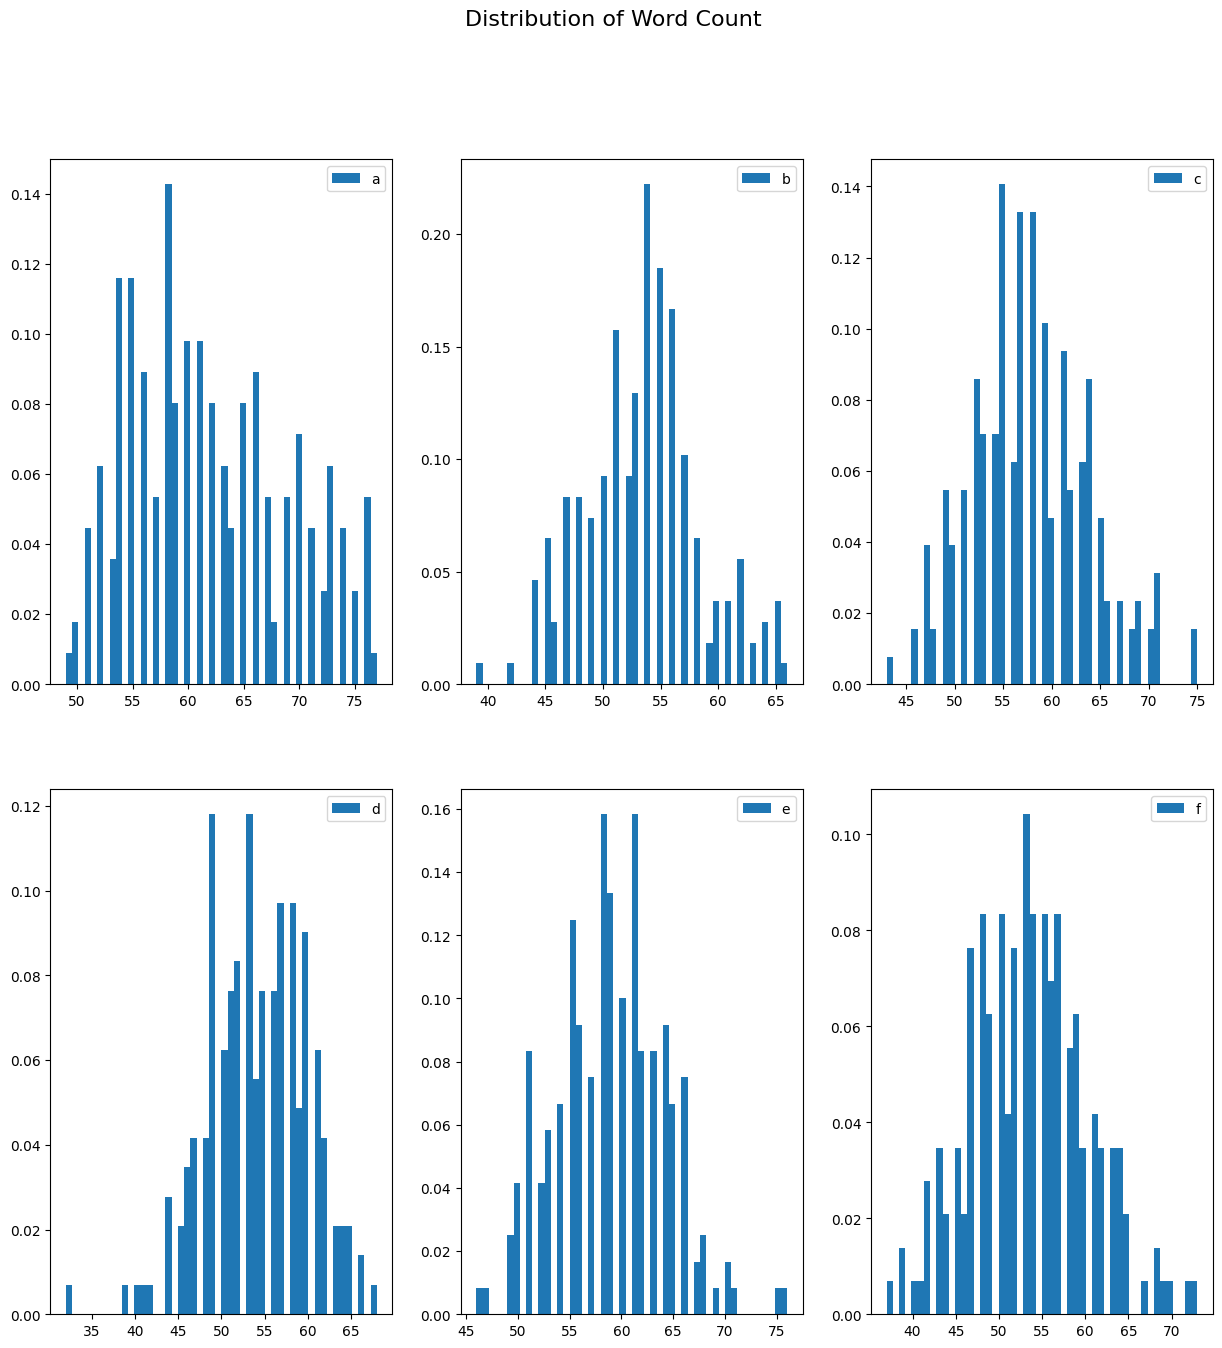

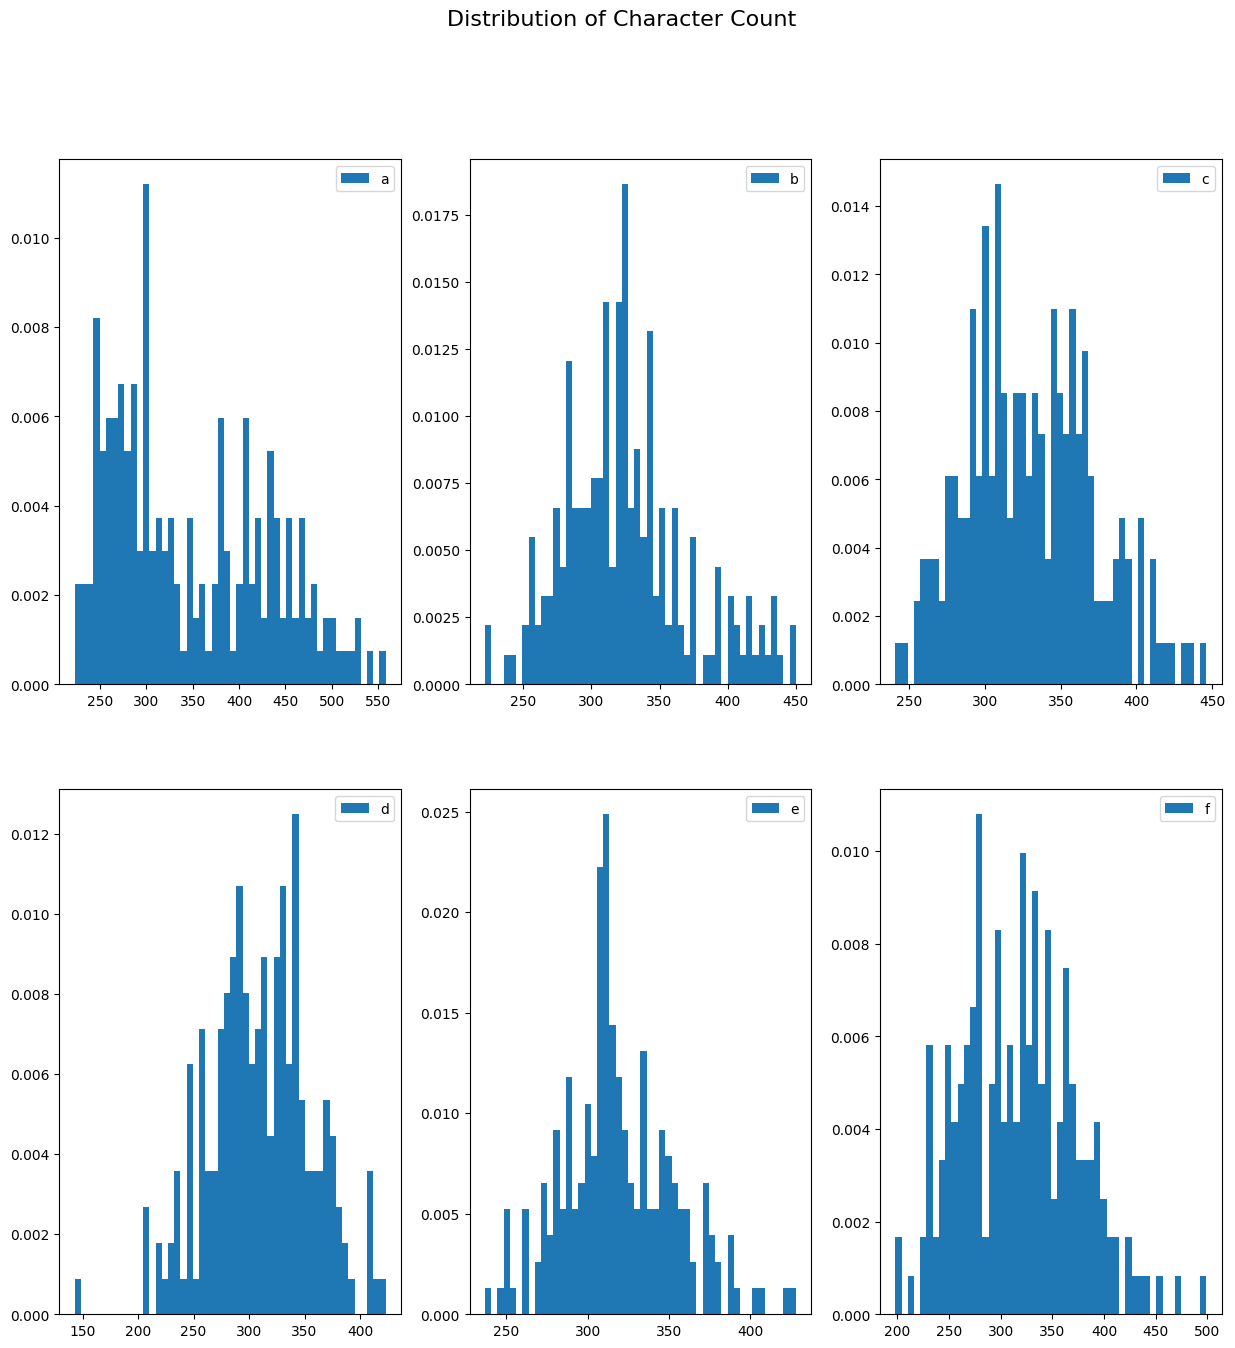

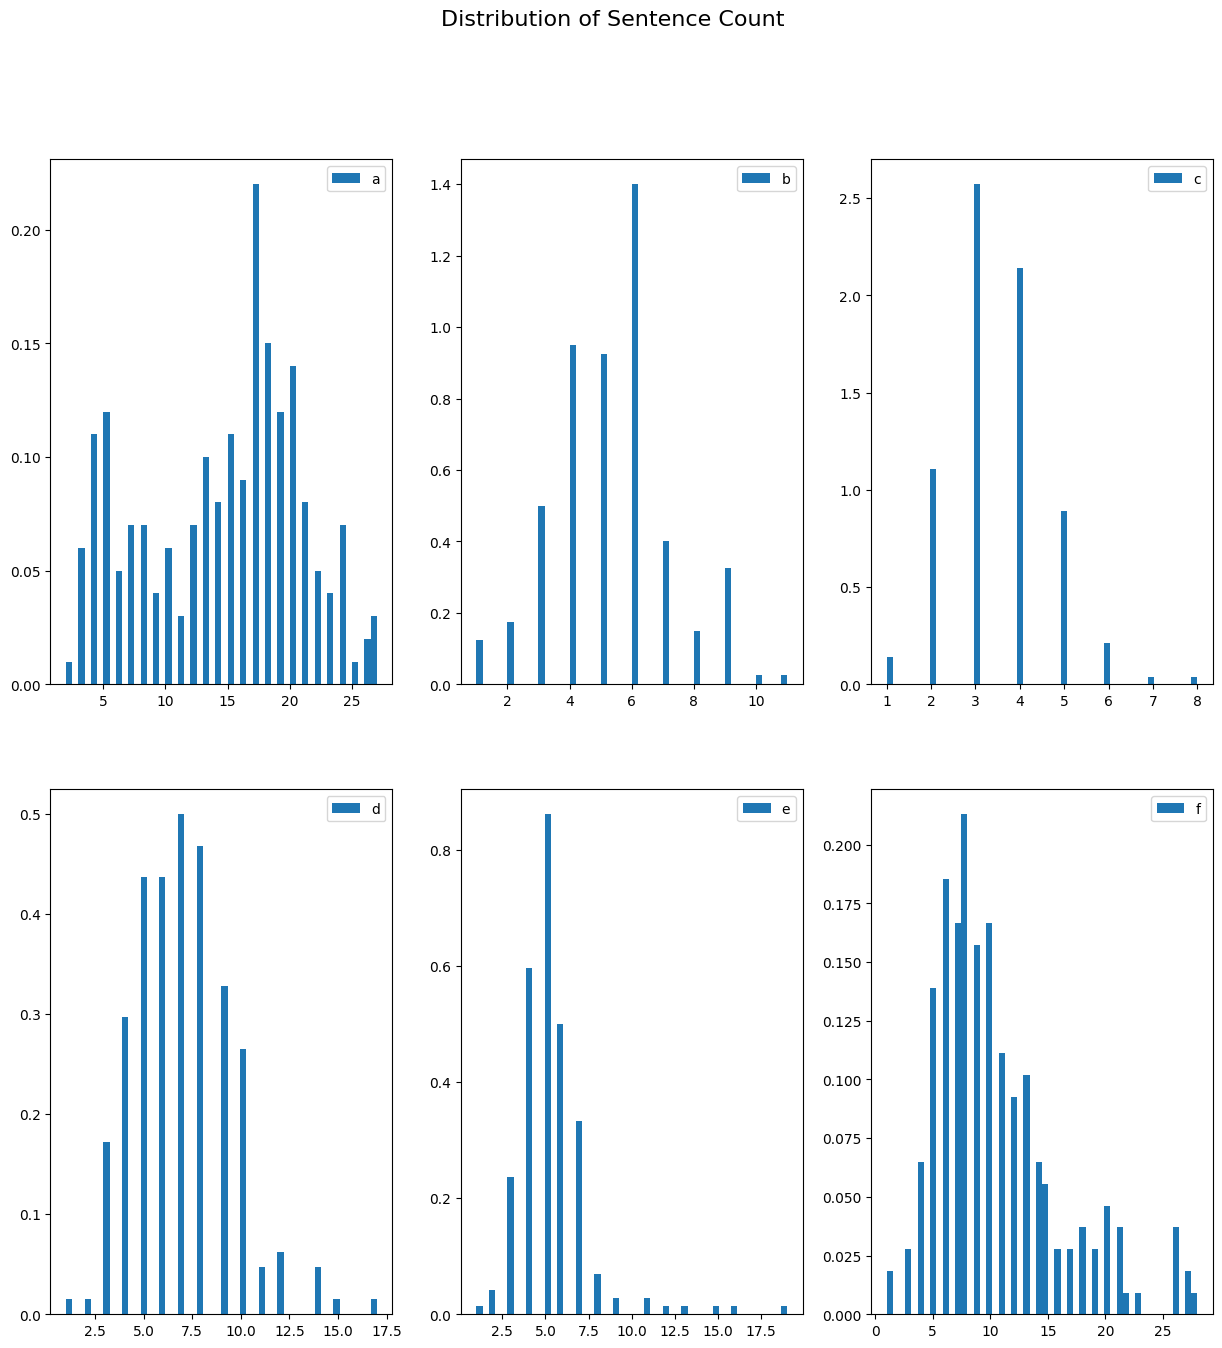

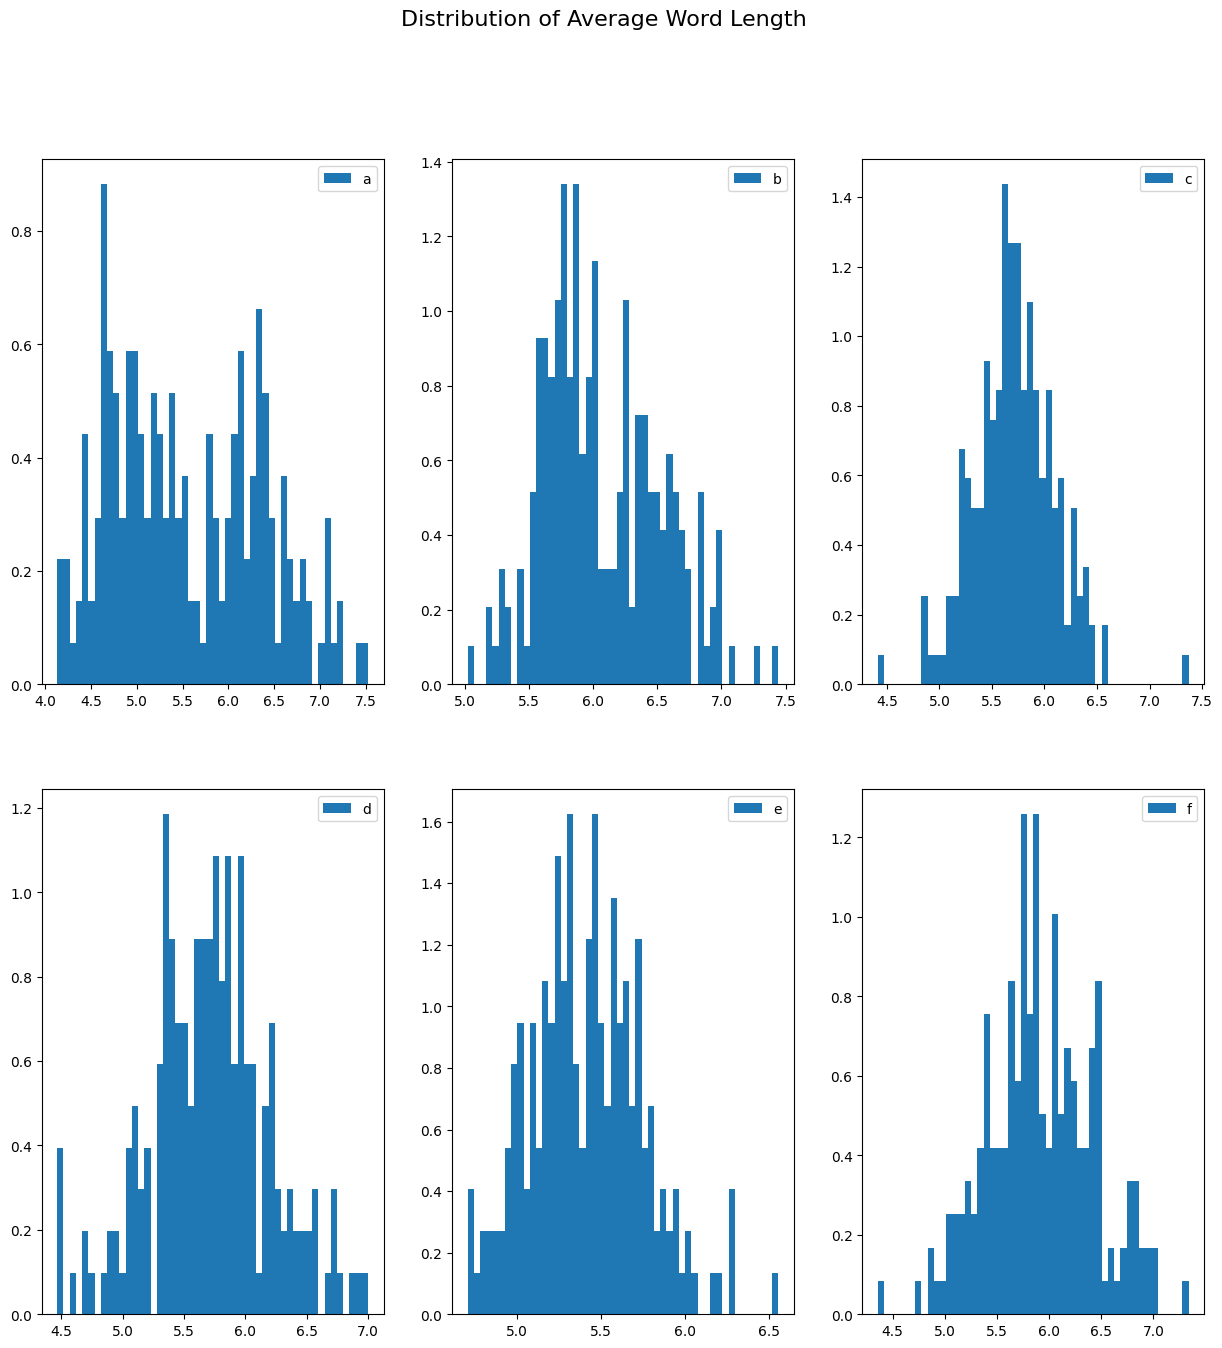

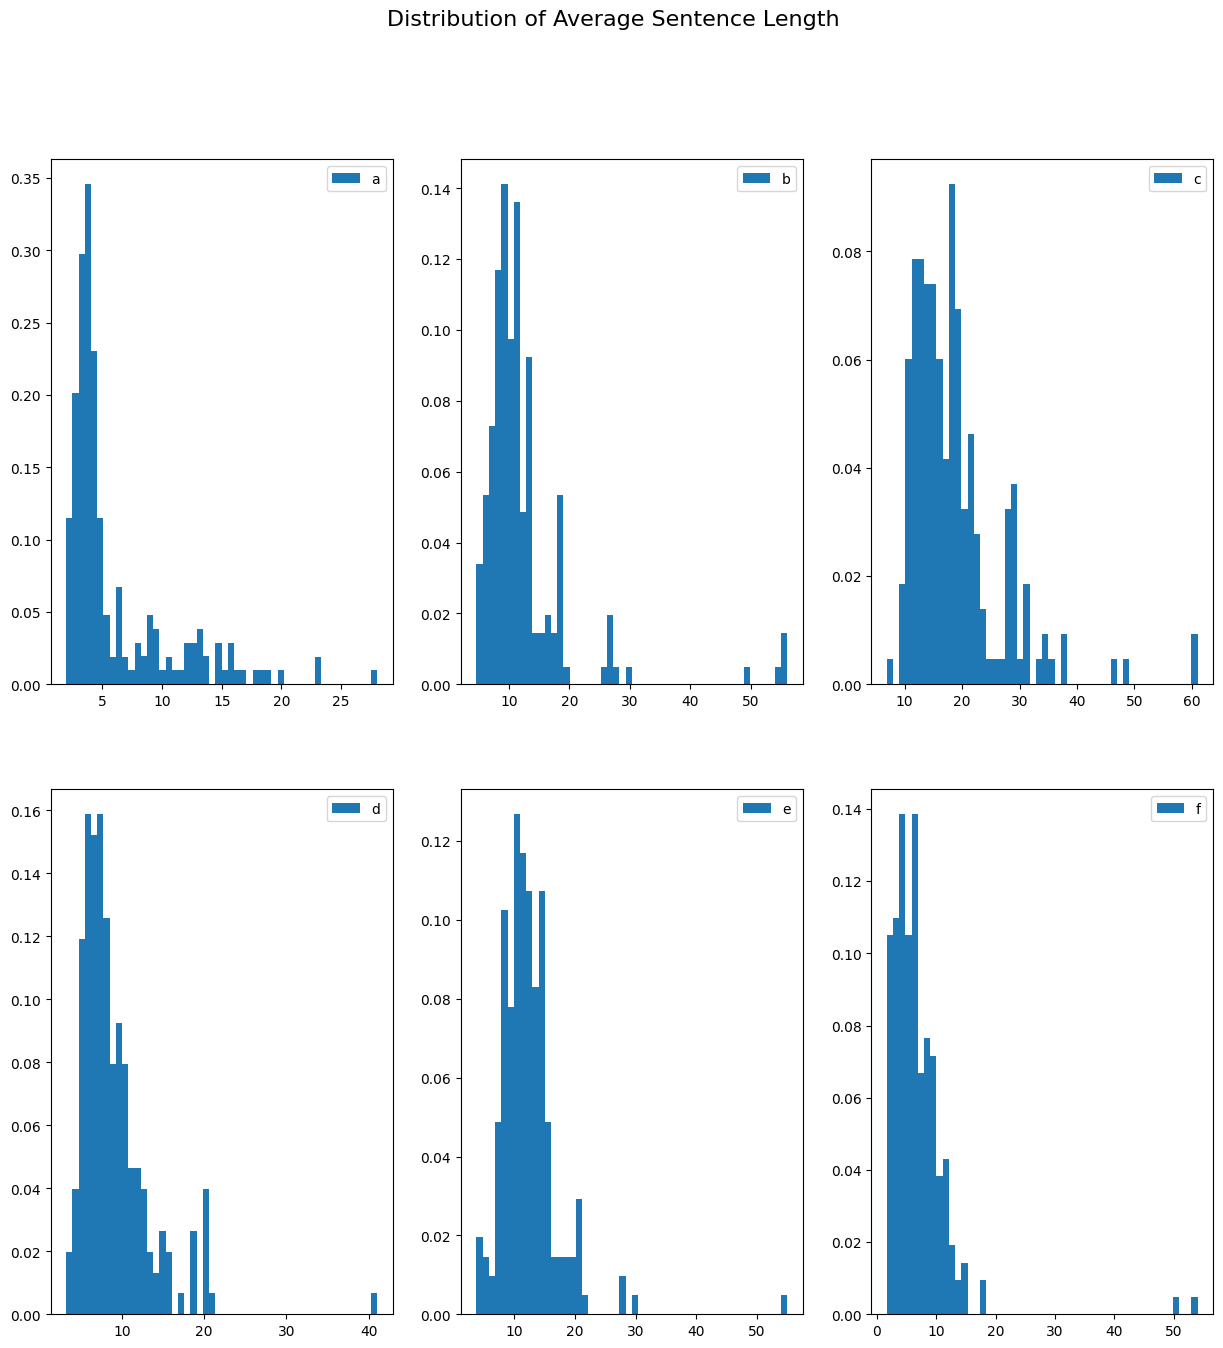

In [14]:
# Evaluation of new features using histograms:
Labels= data['Label'].unique()

# Distribution of Word Count
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Word Count', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Word_count'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

# Distribution of Character Count
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Character Count', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Character_count'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

# Distribution of Sentence Count
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Sentence Count', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Sentence_count'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

# Distribution of Average Word Length
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Average Word Length', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Avg_word_length'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

# Distribution of Average Sentence Length
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Average Sentence Length', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Avg_sentence_length'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

## **Sentiment Analysis**

The TextBlob library in Python is a simple natural language processing (NLP) library for processing textual data. The sentiment.polarity attribute of a TextBlob object is used to calculate the sentiment polarity of a text. The sentiment.polarity attribute returns a value between -1 and 1, where:

-1 indicates a negative sentiment,
0 indicates a neutral sentiment, and
1 indicates a positive sentiment.

In [15]:
# New feature: Sentiment Polarity
data['Sentiment_polarity']= data['Partition_lemmatized'].apply(lambda x: TextBlob(x).sentiment.polarity)
data

Book Title         Book Author Label  \
0            The Alchemist          Ben Jonson     a   
1            The Alchemist          Ben Jonson     a   
2            The Alchemist          Ben Jonson     a   
3            The Alchemist          Ben Jonson     a   
4            The Alchemist          Ben Jonson     a   
...                    ...                 ...   ...   
1195  Crime and Punishment  Fyodor Dostoyevsky     f   
1196  Crime and Punishment  Fyodor Dostoyevsky     f   
1197  Crime and Punishment  Fyodor Dostoyevsky     f   
1198  Crime and Punishment  Fyodor Dostoyevsky     f   
1199  Crime and Punishment  Fyodor Dostoyevsky     f   

                                              Partition  \
0     heat a little water quickly ; Subtle must shav...   
1     `` But that a rook by wearing a pied feather ,...   
2     Yes . Let them stand bare , as do their audito...   
3     use ; yet still loth to be gull 'd : I do not ...   
4     war of the theatres must have been long since ...   
...                                                 ...   
1195  for you. ” “ Good heavens ! ” cried Pulcheria ...   
1196  ’ ll dance again . Why are you whimpering ? Wh...   
1197  he began skipping about the room and punching ...   
1198  , no doubt , over me ! Not a doubt they were t...   
1199  calmly at the Neva , at the glowing red sun se...   

                                      Partition_stemmed  \
0     heat littl water quickli subtl must shave capt...   
1     rook wear pie feather cabl hatband threepil ru...   
2     ye let stand bare auditori cap new shingl mam ...   
3     use yet still loth gull like philosoph bawd st...   
4     war theatr must long sinc heal jonson chapman ...   
...                                                 ...   
1195  good heaven cri pulcheria alexandrovna razumih...   
1196  danc whimper whimper afraid stupid good rodion...   
1197  began skip room punch chest scoundrel mean kno...   
1198  doubt doubt talk came know flat make hast said...   
1199  calmli neva glow red sun set glow sky spite we...   

                                   Partition_lemmatized  Word_count  \
0     heat little water quickly subtle must shave ca...          65   
1     rook wearing pied feather cable hatband threep...          60   
2     yes let stand bare auditory cap new shingle ma...          62   
3     use yet still loth gull like philosophical baw...          55   
4     war theatre must long since healed jonson chap...          70   
...                                                 ...         ...   
1195  good heaven cried pulcheria alexandrovna razum...          53   
1196  dance whimpering whimpering afraid stupid good...          51   
1197  began skipping room punching chest scoundrel m...          46   
1198  doubt doubt talking came know flat make haste ...          47   
1199  calmly neva glowing red sun setting glowing sk...          56   

      Character_count  Sentence_count  Avg_word_length  Avg_sentence_length  \
0                 276              27         4.246154             2.407407   
1                 408               3         6.800000            20.000000   
2                 293               7         4.725806             8.857143   
3                 274              17         4.981818             3.235294   
4                 454               8         6.485714             8.750000   
...               ...             ...              ...                  ...   
1195              329              13         6.207547             4.076923   
1196              331               4         6.490196            12.750000   
1197              264               5         5.739130             9.200000   
1198              232              21         4.936170             2.238095   
1199              364               5         6.500000            11.200000   

      Sentiment_polarity  
0               0.168452  
1               0.033730  
2               0.120522  
3              

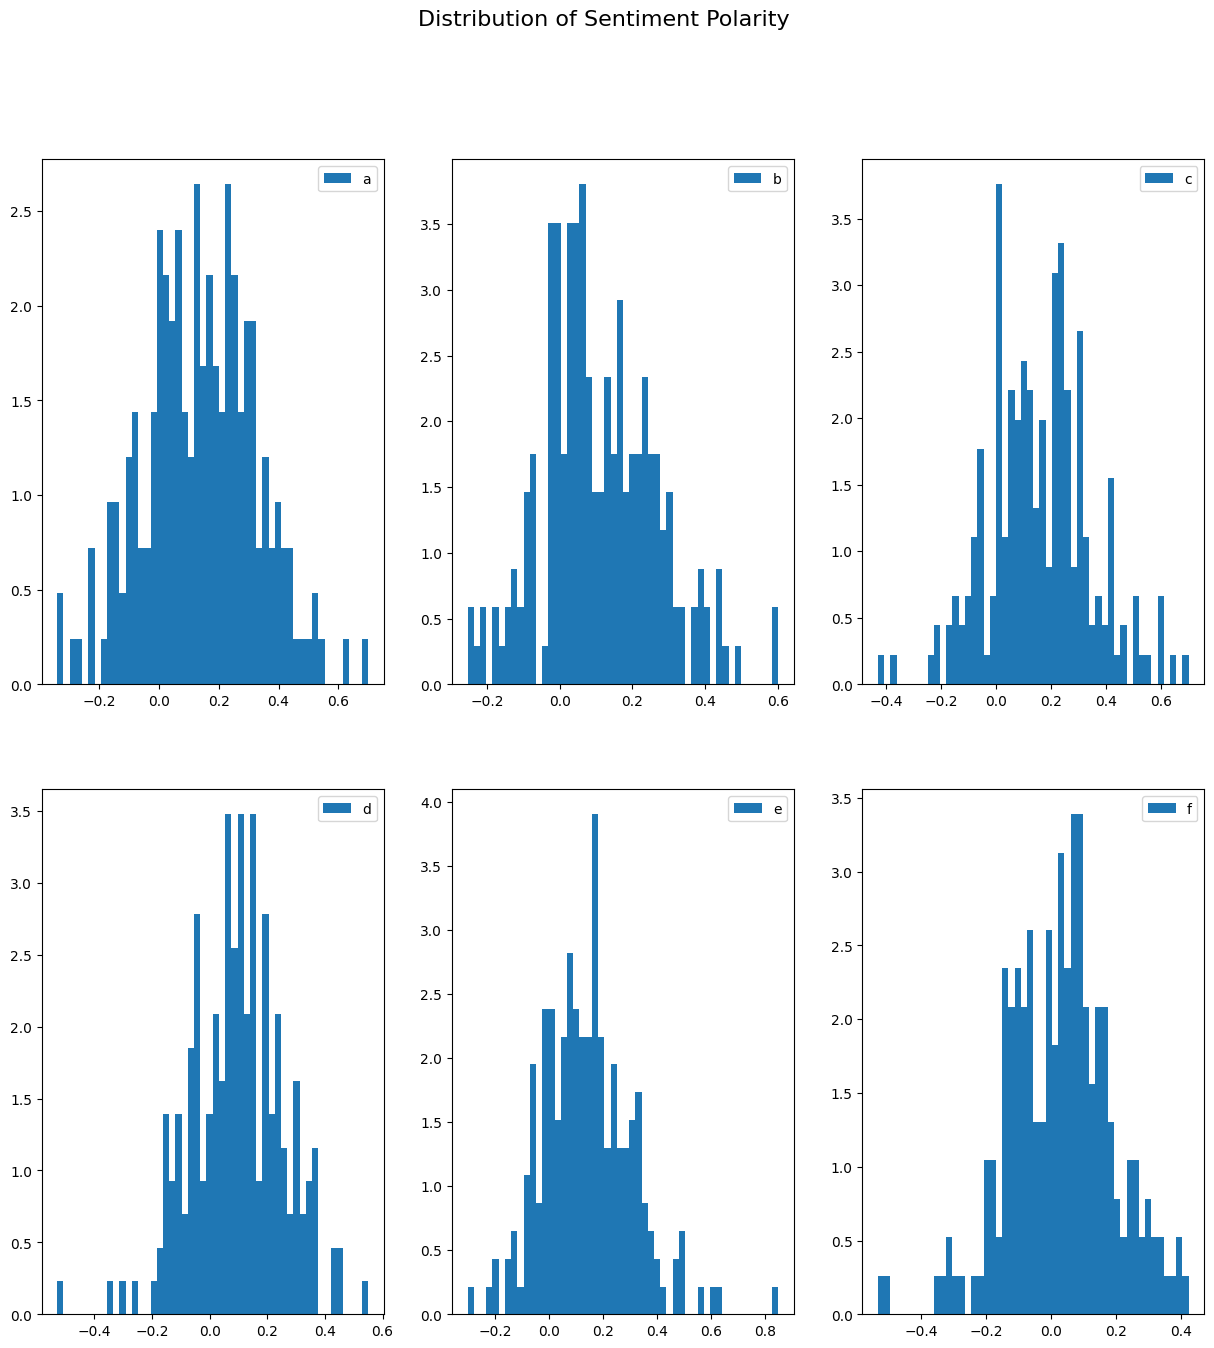

In [16]:
# Evaluation of Sentiment Polarity Feature using histograms:
# Distribution of Sentiment Polarity
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Sentiment Polarity', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Sentiment_polarity'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

In [17]:
# New feature: Sentiment Subjectivity
data['Sentiment_subjectivity']= data['Partition_lemmatized'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
data

Book Title         Book Author Label  \
0            The Alchemist          Ben Jonson     a   
1            The Alchemist          Ben Jonson     a   
2            The Alchemist          Ben Jonson     a   
3            The Alchemist          Ben Jonson     a   
4            The Alchemist          Ben Jonson     a   
...                    ...                 ...   ...   
1195  Crime and Punishment  Fyodor Dostoyevsky     f   
1196  Crime and Punishment  Fyodor Dostoyevsky     f   
1197  Crime and Punishment  Fyodor Dostoyevsky     f   
1198  Crime and Punishment  Fyodor Dostoyevsky     f   
1199  Crime and Punishment  Fyodor Dostoyevsky     f   

                                              Partition  \
0     heat a little water quickly ; Subtle must shav...   
1     `` But that a rook by wearing a pied feather ,...   
2     Yes . Let them stand bare , as do their audito...   
3     use ; yet still loth to be gull 'd : I do not ...   
4     war of the theatres must have been long since ...   
...                                                 ...   
1195  for you. ” “ Good heavens ! ” cried Pulcheria ...   
1196  ’ ll dance again . Why are you whimpering ? Wh...   
1197  he began skipping about the room and punching ...   
1198  , no doubt , over me ! Not a doubt they were t...   
1199  calmly at the Neva , at the glowing red sun se...   

                                      Partition_stemmed  \
0     heat littl water quickli subtl must shave capt...   
1     rook wear pie feather cabl hatband threepil ru...   
2     ye let stand bare auditori cap new shingl mam ...   
3     use yet still loth gull like philosoph bawd st...   
4     war theatr must long sinc heal jonson chapman ...   
...                                                 ...   
1195  good heaven cri pulcheria alexandrovna razumih...   
1196  danc whimper whimper afraid stupid good rodion...   
1197  began skip room punch chest scoundrel mean kno...   
1198  doubt doubt talk came know flat make hast said...   
1199  calmli neva glow red sun set glow sky spite we...   

                                   Partition_lemmatized  Word_count  \
0     heat little water quickly subtle must shave ca...          65   
1     rook wearing pied feather cable hatband threep...          60   
2     yes let stand bare auditory cap new shingle ma...          62   
3     use yet still loth gull like philosophical baw...          55   
4     war theatre must long since healed jonson chap...          70   
...                                                 ...         ...   
1195  good heaven cried pulcheria alexandrovna razum...          53   
1196  dance whimpering whimpering afraid stupid good...          51   
1197  began skipping room punching chest scoundrel m...          46   
1198  doubt doubt talking came know flat make haste ...          47   
1199  calmly neva glowing red sun setting glowing sk...          56   

      Character_count  Sentence_count  Avg_word_length  Avg_sentence_length  \
0                 276              27         4.246154             2.407407   
1                 408               3         6.800000            20.000000   
2                 293               7         4.725806             8.857143   
3                 274              17         4.981818             3.235294   
4                 454               8         6.485714             8.750000   
...               ...             ...              ...                  ...   
1195              329              13         6.207547             4.076923   
1196              331               4         6.490196            12.750000   
1197              264               5         5.739130             9.200000   
1198              232              21         4.936170             2.238095   
1199              364               5         6.500000            11.200000   

      Sentiment_polarity  Sentiment_subjectivity  
0               0.168452                0.442857  
1               0.033

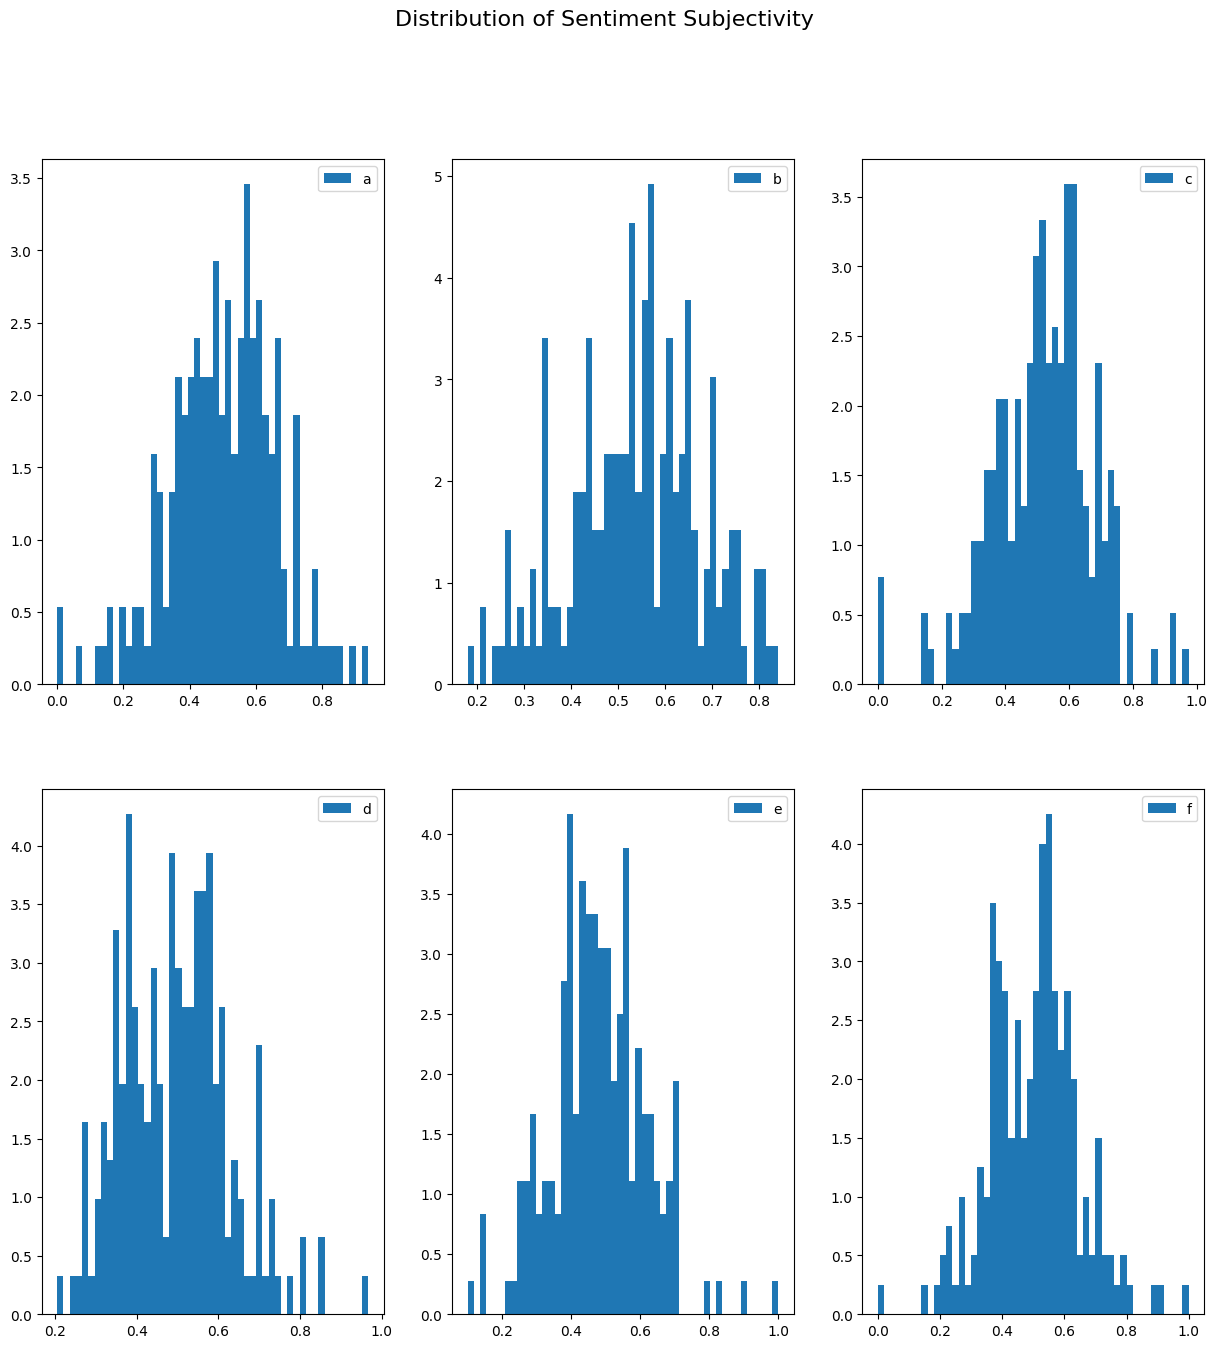

In [18]:
# Evaluation of Sentiment Subjectivity Feature using histograms:
# Distribution of Sentiment Subjectivity
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))  # Adjust the width and height as needed
fig.suptitle('Distribution of Sentiment Subjectivity', fontsize=16)
for i in range(2):
  for j in range(3):
    axes[i,j].hist(data[data['Label']==Labels[np.ravel_multi_index((i,j), (2,3))]]['Sentiment_subjectivity'], bins=50, density=True, label= Labels[np.ravel_multi_index((i,j), (2,3))]) # alpha tells how dark the shade of the histogram must be, normed= True to normalize our plots to the same scale because there is a lot more ham than spam
    axes[i,j].legend(loc='upper right')
plt.show()

## **Most Frequent Words in each book**

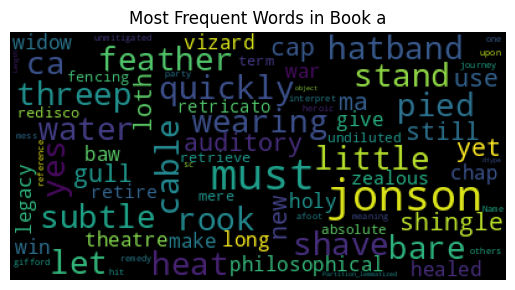

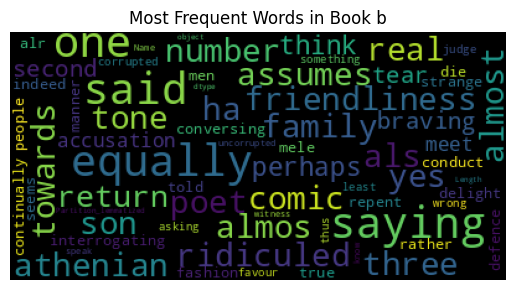

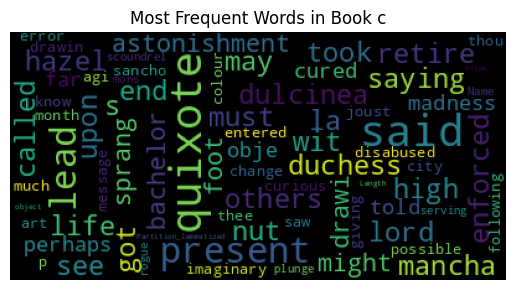

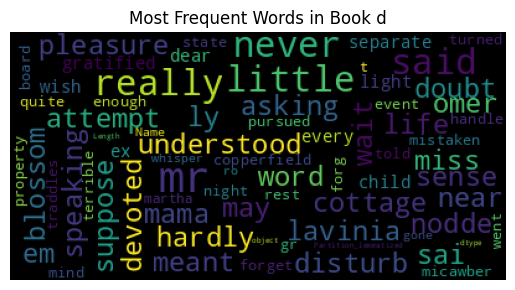

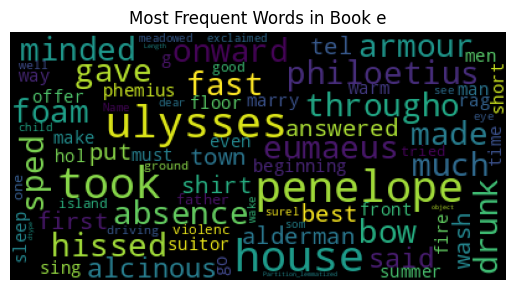

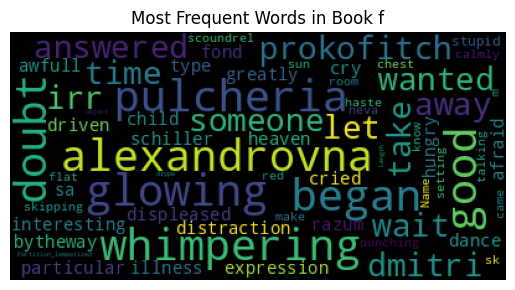

In [19]:
# Most frequent words in each book
for y in data['Label'].unique():
  corpus = data[data['Label']==y]['Partition_lemmatized']
  wc = wordcloud.WordCloud(background_color='black', max_words=100, max_font_size=35)
  wc = wc.generate(str(corpus))
  fig = plt.figure(num=1)
  plt.axis('off')
  plt.title('Most Frequent Words in Book {}'.format(y))
  plt.imshow(wc, cmap=None)
  plt.show()

## **Most Frequent Unigrams and Bigrams in each book**

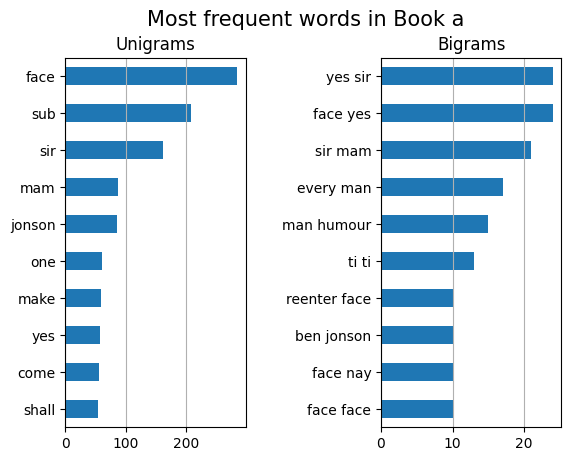

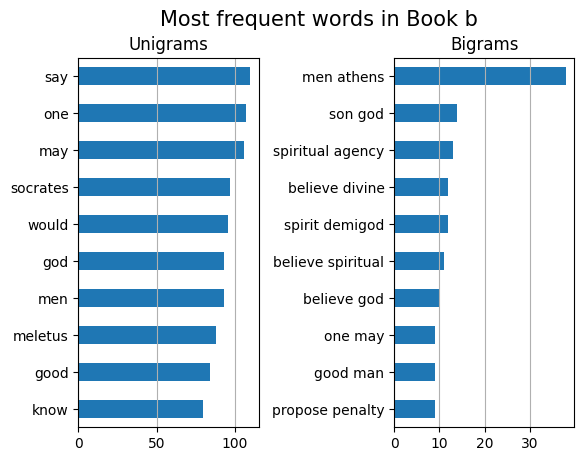

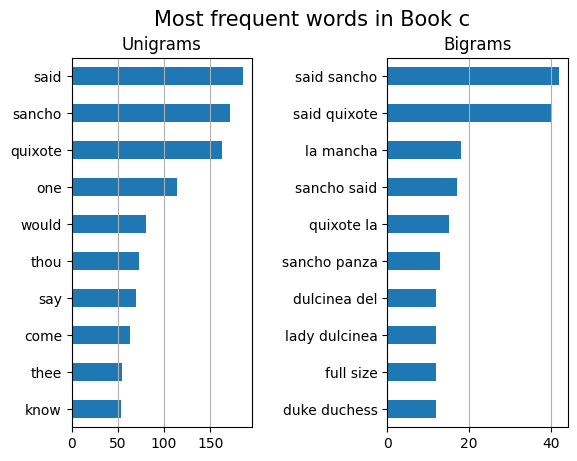

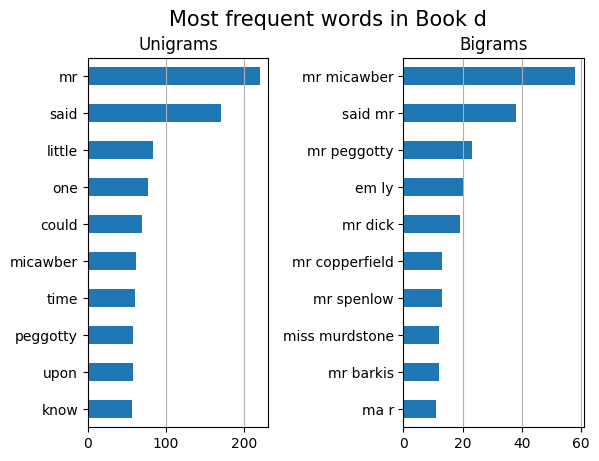

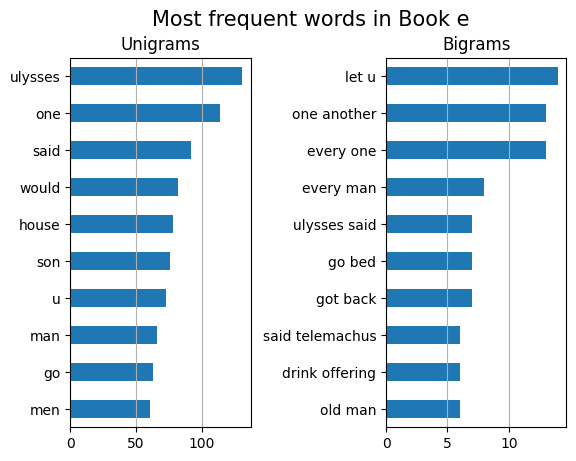

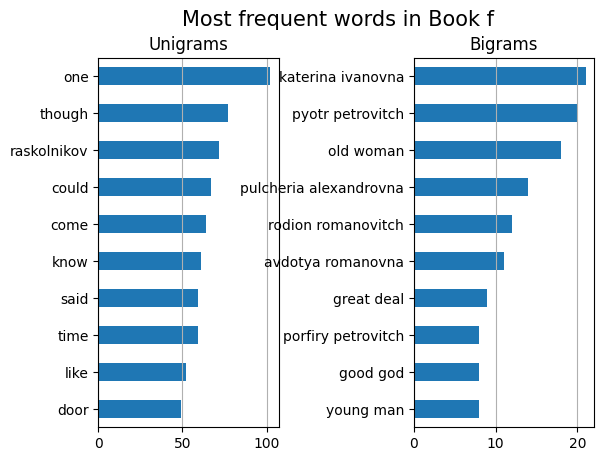

In [20]:
top= 10
for y in data['Label'].unique():
  corpus = data[data['Label']==y]['Partition_lemmatized']
  lst_tokens = get_tokens(corpus.str.cat(sep=" "))
  fig, ax = plt.subplots(nrows=1, ncols=2)
  fig.suptitle("Most frequent words in Book {}".format(y), fontsize=15)
  ## unigrams
  dic_words_freq = nltk.FreqDist(lst_tokens)
  dtf_uni = pd.DataFrame(dic_words_freq.most_common(),columns=["Word","Freq"])
  dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(kind="barh", title="Unigrams", ax=ax[0],legend=False).grid(axis='x')
  ax[0].set(ylabel=None)
  ## bigrams
  dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
  dtf_bi = pd.DataFrame(dic_words_freq.most_common(),columns=["Word","Freq"])
  dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(string for string in x) )
  dtf_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(kind="barh", title="Bigrams", ax=ax[1],legend=False).grid(axis='x')
  ax[1].set(ylabel=None)
  plt.subplots_adjust(wspace=0.75)
  plt.show()

## **Top 10 collocations in each book**

In [21]:
def find_top_collocations(data,label):
  docs = data[data['Label']==label]['Partition_lemmatized']
  author_allwords = [word for doc in docs for word in get_tokens(doc)]

  bigram_measures = BigramAssocMeasures()
  finder = BigramCollocationFinder.from_words(author_allwords)
  finder.apply_freq_filter(3)
  top_collocations = finder.nbest(bigram_measures.pmi, 10) ## Top 10 frequency collocations
  return top_collocations

In [22]:
for y in data['Label'].unique():
  top_collocations= find_top_collocations(data,y)
  print('Top 10 collocations in Book {}: {}'.format(y,top_collocations))

Top 10 collocations in Book a: [('6d', 'thirdborough'), ('administration', 'mango'), ('almond', 'sugar'), ('avail', 'borachio'), ('balneo', 'vaporoso'), ('bermuda', 'labyrinth'), ('bonnyclabber', 'sour'), ('bookholder', 'prompter'), ('bordello', 'brothel'), ('buttermilk', 'bookholder')]
Top 10 collocations in Book b: [('45', 'b'), ('ambitious', 'energetic'), ('array', 'persuasive'), ('battle', 'array'), ('cared', 'straw'), ('clazomenian', 'full'), ('condemnation', 'expected'), ('contained', 'manifestly'), ('crime', 'showed'), ('defect', 'overshadowed')]
Top 10 collocations in Book c: [('consigned', 'oblivion'), ('feather', 'mattress'), ('fulling', 'mill'), ('hazel', 'nut'), ('tom', 'cecial'), ('battered', 'weary'), ('feeling', 'p04bjpg'), ('late', 'fray'), ('practised', 'presence'), ('doña', 'rodriguez')]
Top 10 collocations in Book d: [('mary', 'anne'), ('infinite', 'variety'), ('ma', 'r'), ('answer', 'question'), ('hundred', 'pound'), ('r', 'davy'), ('ha', 'ha'), ('rosa', 'dartle'), 

# **Feature Engineering: Transform the data**

Check for distributions that are skewed i.e. having a tail extending out with some outliers. A model might dig too much into this skewed tail and generate a model maybe that's a little bit biased, so it's important to transform features with such distributions.

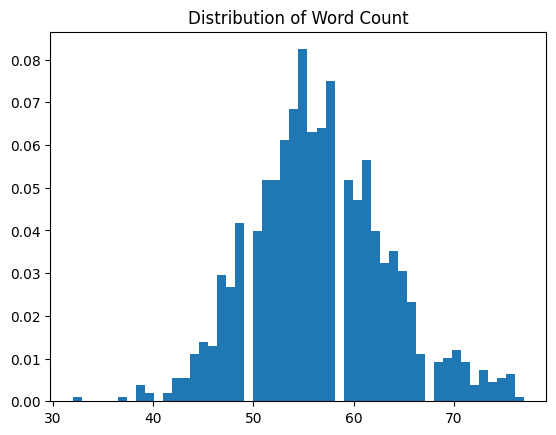

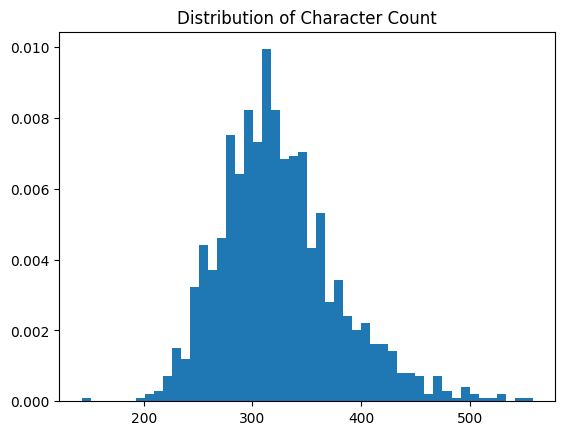

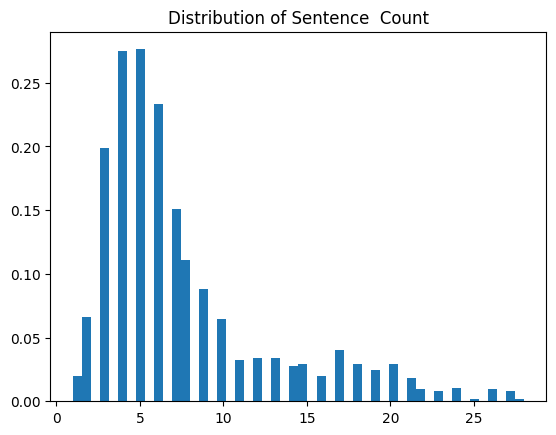

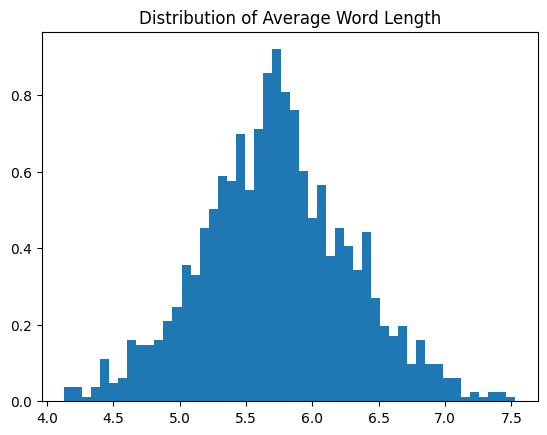

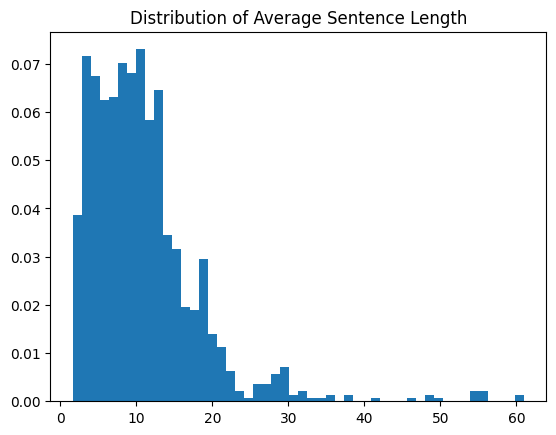

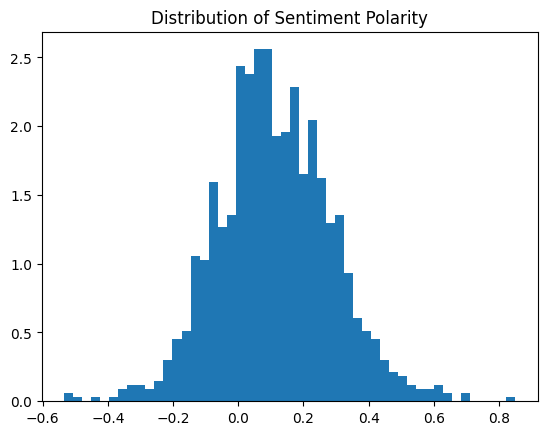

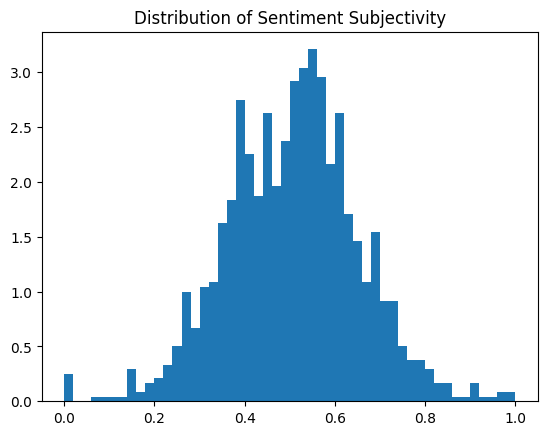

In [23]:
# Distribution of Word Count
plt.title('Distribution of Word Count')
plt.hist(data['Word_count'], bins=50, density=True)
plt.show()

# Distribution of Character Count
plt.title('Distribution of Character Count')
plt.hist(data['Character_count'], bins=50, density=True)
plt.show()

# Distribution of Sentence Count
plt.title('Distribution of Sentence  Count')
plt.hist(data['Sentence_count'], bins=50, density=True)
plt.show()

# Distribution of Average Word Length
plt.title('Distribution of Average Word Length')
plt.hist(data['Avg_word_length'], bins=50, density=True)
plt.show()

# Distribution of Average Sentence Length
plt.title('Distribution of Average Sentence Length')
plt.hist(data['Avg_sentence_length'], bins=50, density=True)
plt.show()

# Distribution of sentiment polarity
plt.title('Distribution of Sentiment Polarity')
plt.hist(data['Sentiment_polarity'], bins=50, density=True)
plt.show()

# Distribution of sentiment subjectivity
plt.title('Distribution of Sentiment Subjectivity')
plt.hist(data['Sentiment_subjectivity'], bins=50, density=True)
plt.show()

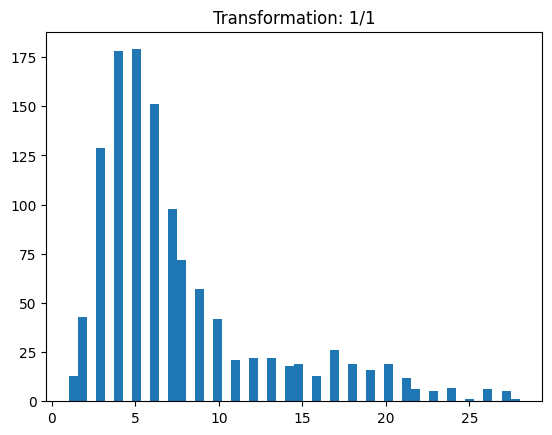

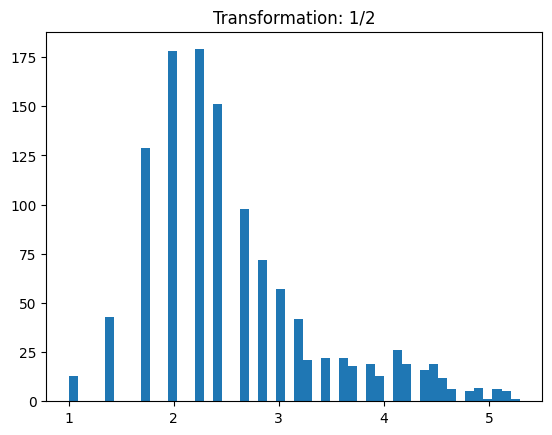

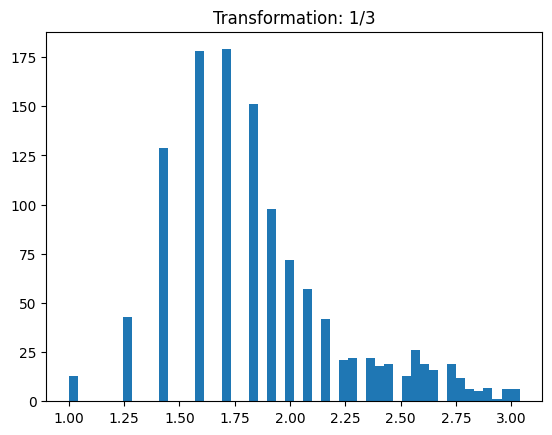

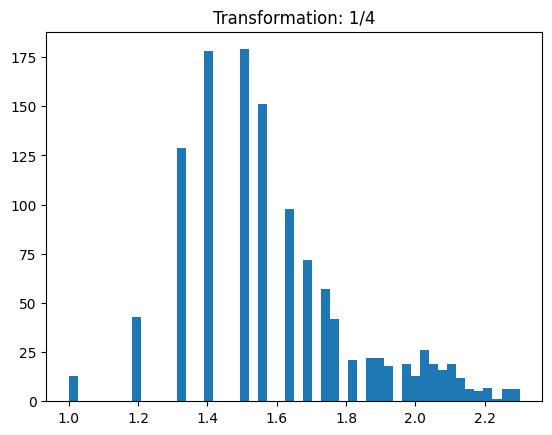

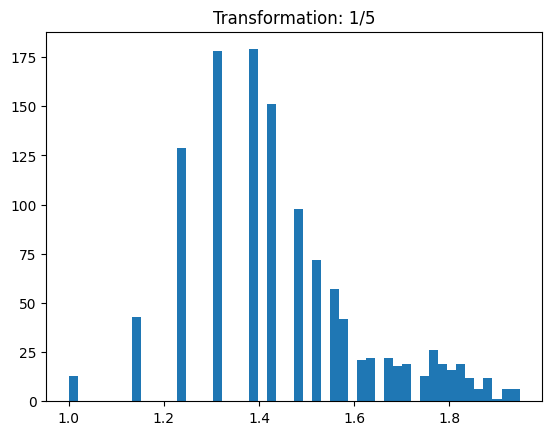

In [24]:
# Box-Cox Power Transformation of Sentence Count
# First we determine what range of exponents we want to test out. So in our example we had a range from negative two to positive two. And that's a commonly used range. Then we'll apply these transformations to each value in the feature we like to transform. Then we will use some criteria to determine which of the transformations yielded the best distribution. We can find different criteria to use to determine the best distribution, but today, we're just going to plot it in a histogram and pick the one that looks the most like a normal distribution because this means it'll be a nice and compact distribution that'll be easier for the model to use.
for i in [1,2,3,4,5]:
   # [] is list of exponents
   plt.hist((data['Sentence_count'])**(1/i), bins=50) # we actually want exponent 1/i here and not i
   plt.title('Transformation: 1/{}'.format(i))
   plt.show()

In [25]:
data['Sentence_count']= data['Sentence_count']**(1/5)

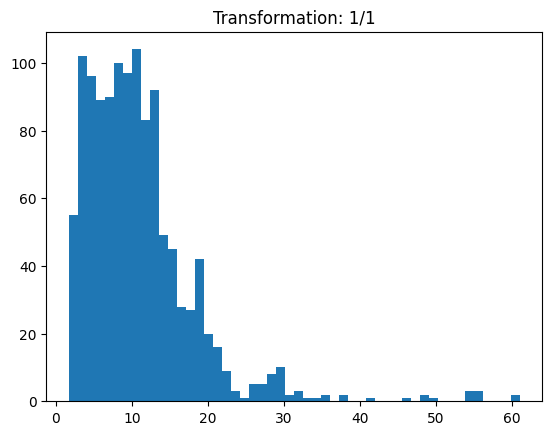

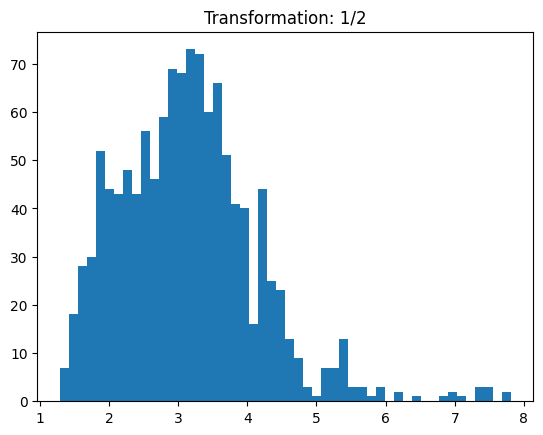

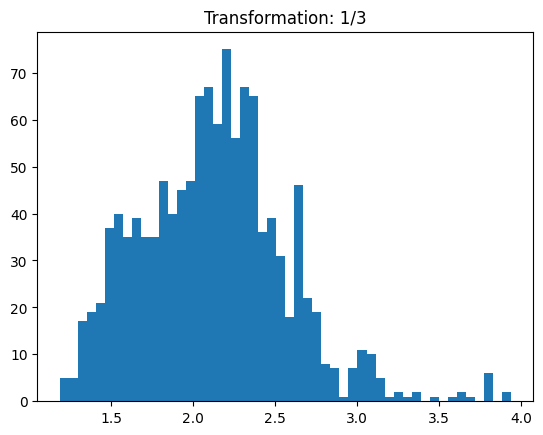

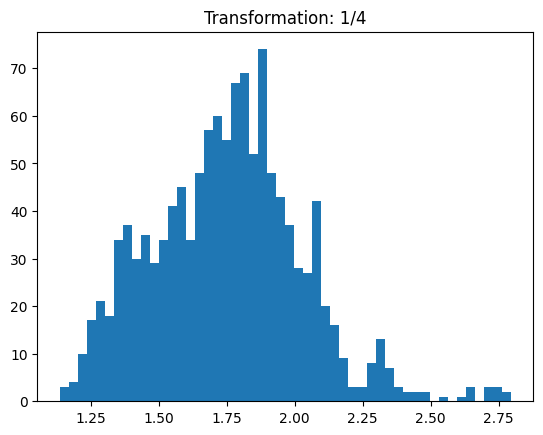

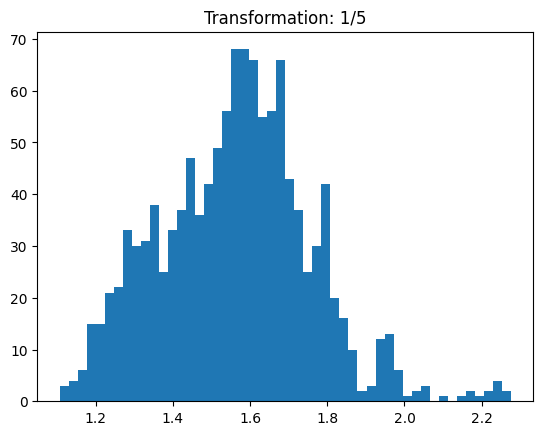

In [26]:
# Box-Cox Power Transformation of Average Sentence Length
# First we determine what range of exponents we want to test out. So in our example we had a range from negative two to positive two. And that's a commonly used range. Then we'll apply these transformations to each value in the feature we like to transform. Then we will use some criteria to determine which of the transformations yielded the best distribution. We can find different criteria to use to determine the best distribution, but today, we're just going to plot it in a histogram and pick the one that looks the most like a normal distribution because this means it'll be a nice and compact distribution that'll be easier for the model to use.
for i in [1,2,3,4,5]:
   # [] is list of exponents
   plt.hist((data['Avg_sentence_length'])**(1/i), bins=50) # we actually want exponent 1/i here and not i
   plt.title('Transformation: 1/{}'.format(i))
   plt.show()

In [27]:
data['Avg_sentence_length']= data['Avg_sentence_length']**(1/5)

In [28]:
data

Book Title         Book Author Label  \
0            The Alchemist          Ben Jonson     a   
1            The Alchemist          Ben Jonson     a   
2            The Alchemist          Ben Jonson     a   
3            The Alchemist          Ben Jonson     a   
4            The Alchemist          Ben Jonson     a   
...                    ...                 ...   ...   
1195  Crime and Punishment  Fyodor Dostoyevsky     f   
1196  Crime and Punishment  Fyodor Dostoyevsky     f   
1197  Crime and Punishment  Fyodor Dostoyevsky     f   
1198  Crime and Punishment  Fyodor Dostoyevsky     f   
1199  Crime and Punishment  Fyodor Dostoyevsky     f   

                                              Partition  \
0     heat a little water quickly ; Subtle must shav...   
1     `` But that a rook by wearing a pied feather ,...   
2     Yes . Let them stand bare , as do their audito...   
3     use ; yet still loth to be gull 'd : I do not ...   
4     war of the theatres must have been long since ...   
...                                                 ...   
1195  for you. ” “ Good heavens ! ” cried Pulcheria ...   
1196  ’ ll dance again . Why are you whimpering ? Wh...   
1197  he began skipping about the room and punching ...   
1198  , no doubt , over me ! Not a doubt they were t...   
1199  calmly at the Neva , at the glowing red sun se...   

                                      Partition_stemmed  \
0     heat littl water quickli subtl must shave capt...   
1     rook wear pie feather cabl hatband threepil ru...   
2     ye let stand bare auditori cap new shingl mam ...   
3     use yet still loth gull like philosoph bawd st...   
4     war theatr must long sinc heal jonson chapman ...   
...                                                 ...   
1195  good heaven cri pulcheria alexandrovna razumih...   
1196  danc whimper whimper afraid stupid good rodion...   
1197  began skip room punch chest scoundrel mean kno...   
1198  doubt doubt talk came know flat make hast said...   
1199  calmli neva glow red sun set glow sky spite we...   

                                   Partition_lemmatized  Word_count  \
0     heat little water quickly subtle must shave ca...          65   
1     rook wearing pied feather cable hatband threep...          60   
2     yes let stand bare auditory cap new shingle ma...          62   
3     use yet still loth gull like philosophical baw...          55   
4     war theatre must long since healed jonson chap...          70   
...                                                 ...         ...   
1195  good heaven cried pulcheria alexandrovna razum...          53   
1196  dance whimpering whimpering afraid stupid good...          51   
1197  began skipping room punching chest scoundrel m...          46   
1198  doubt doubt talking came know flat make haste ...          47   
1199  calmly neva glowing red sun setting glowing sk...          56   

      Character_count  Sentence_count  Avg_word_length  Avg_sentence_length  \
0                 276        1.933182         4.246154             1.192092   
1                 408        1.245731         6.800000             1.820564   
2                 293        1.475773         4.725806             1.546887   
3                 274        1.762340         4.981818             1.264686   
4                 454        1.515717         6.485714             1.543127   
...               ...             ...              ...                  ...   
1195              329        1.670278         6.207547             1.324544   
1196              331        1.319508         6.490196             1.663804   
1197              264        1.379730         5.739130             1.558682   
1198              232        1.838416         4.936170             1.174832   
1199              364        1.379730         6.500000             1.621226   

      Sentiment_polarity  Sentiment_subjectivity  
0               0.168452                0.442857  
1               0.033

# **Feature Engineering: Vectorization**

## **BOW/Count Vectorization**

In [29]:
# Instantiate CountVectorizer object and define parameters
BOW_vect= CountVectorizer()

# Fit CountVectorizer it to our text corpus ie train the vectorizer object to learn what words are in the corpus and then use it to vectorize our data ie transform our data into feature vectors
data_BOW= BOW_vect.fit_transform(data['Partition_lemmatized'])

# Expand the sparse matrix to a collection of arrays and store collection of arrays into a data frame
data_BOW= pd.DataFrame(data_BOW.toarray())
data_BOW.columns= BOW_vect.get_feature_names_out()

In [30]:
data_BOW.shape

(1200, 10672)

In [31]:
data_BOW.head()

10  100  101  110  119k  12  128  129  13  130  ...  zethus  zeus  \
0   0    0    0    0     0   0    0    0   0    0  ...       0     0   
1   0    0    0    0     0   0    0    0   0    0  ...       0     0   
2   0    0    0    0     0   0    0    0   0    0  ...       0     0   
3   0    0    0    0     0   0    0    0   0    0  ...       0     0   
4   0    0    0    0     0   0    0    0   0    0  ...       0     0   

   zoroastric  zossimov  álvaro  θρόνος  θρῆνυς  νηρίτῳ  νηίῳ  ὀρσοθύρα  
0           0         0       0       0       0       0     0         0  
1           0         0       0       0       0       0     0         0  
2           0         0       0       0       0       0     0         0  
3           0         0       0       0       0       0     0         0  
4           0         0       0       0       0       0     0         0  

[5 rows x 10672 columns]

In [32]:
# Words that BOW_vect learnt
BOW_vect.vocabulary_

{'heat': 4517,
 'little': 5611,
 'water': 10320,
 'quickly': 7488,
 'subtle': 9119,
 'must': 6210,
 'shave': 8430,
 'captain': 1508,
 'beard': 996,
 'make': 5786,
 'appear': 593,
 'smooth': 8674,
 'jeremy': 5216,
 'sub': 9101,
 'yes': 10639,
 'well': 10369,
 'face': 3552,
 'cut': 2441,
 'throat': 9520,
 'trim': 9748,
 'shall': 8410,
 'see': 8296,
 'sir': 8581,
 'exeunt': 3476,
 'act': 235,
 'scene': 8214,
 '51': 96,
 'lovewit': 5690,
 'door': 2960,
 'enter': 3296,
 'several': 8387,
 'neighbour': 6280,
 'love': 5686,
 'resort': 7857,
 'say': 8193,
 'nei': 6279,
 'daily': 2458,
 'nightly': 6317,
 'ay': 877,
 'brave': 1314,
 'lord': 5668,
 'lady': 5386,
 'gentlewoman': 4111,
 'citizen': 1766,
 'wife': 10464,
 'knight': 5349,
 'rook': 8032,
 'wearing': 10345,
 'pied': 6943,
 'feather': 3645,
 'cable': 1453,
 'hatband': 4463,
 'threepiled': 9511,
 'ruff': 8072,
 'yard': 10629,
 'shoetie': 8467,
 'switzers': 9272,
 'knot': 5360,
 'french': 3973,
 'garter': 4076,
 'affect': 313,
 'humour': 47

## **TF-IDF Vectorization**

In [33]:
# Instantiate TfidfVectorizer object and define parameters
tfidf_vect= TfidfVectorizer()

# Fit TfidfVectorizer it to our text corpus ie train the vectorizer object to learn what words are in the corpus and then use it to vectorize our data ie transform our data into feature vectors
data_tfidf= tfidf_vect.fit_transform(data['Partition_lemmatized'])

# Expand the sparse matrix to a collection of arrays and store collection of arrays to a data frame
data_tfidf= pd.DataFrame(data_tfidf.toarray())
data_tfidf.columns= tfidf_vect.get_feature_names_out()

In [34]:
data_tfidf.shape

(1200, 10672)

In [35]:
data_tfidf.head()

10  100  101  110  119k   12  128  129   13  130  ...  zethus  zeus  \
0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   0.0   
1  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   0.0   
2  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   0.0   
3  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   0.0   
4  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   0.0   

   zoroastric  zossimov  álvaro  θρόνος  θρῆνυς  νηρίτῳ  νηίῳ  ὀρσοθύρα  
0         0.0       0.0     0.0     0.0     0.0     0.0   0.0       0.0  
1         0.0       0.0     0.0     0.0     0.0     0.0   0.0       0.0  
2         0.0       0.0     0.0     0.0     0.0     0.0   0.0       0.0  
3         0.0       0.0     0.0     0.0     0.0     0.0   0.0       0.0  
4         0.0       0.0     0.0     0.0     0.0     0.0   0.0       0.0  

[5 rows x 10672 columns]

In [36]:
# Words that tfidf_vect learnt
tfidf_vect.vocabulary_

{'heat': 4517,
 'little': 5611,
 'water': 10320,
 'quickly': 7488,
 'subtle': 9119,
 'must': 6210,
 'shave': 8430,
 'captain': 1508,
 'beard': 996,
 'make': 5786,
 'appear': 593,
 'smooth': 8674,
 'jeremy': 5216,
 'sub': 9101,
 'yes': 10639,
 'well': 10369,
 'face': 3552,
 'cut': 2441,
 'throat': 9520,
 'trim': 9748,
 'shall': 8410,
 'see': 8296,
 'sir': 8581,
 'exeunt': 3476,
 'act': 235,
 'scene': 8214,
 '51': 96,
 'lovewit': 5690,
 'door': 2960,
 'enter': 3296,
 'several': 8387,
 'neighbour': 6280,
 'love': 5686,
 'resort': 7857,
 'say': 8193,
 'nei': 6279,
 'daily': 2458,
 'nightly': 6317,
 'ay': 877,
 'brave': 1314,
 'lord': 5668,
 'lady': 5386,
 'gentlewoman': 4111,
 'citizen': 1766,
 'wife': 10464,
 'knight': 5349,
 'rook': 8032,
 'wearing': 10345,
 'pied': 6943,
 'feather': 3645,
 'cable': 1453,
 'hatband': 4463,
 'threepiled': 9511,
 'ruff': 8072,
 'yard': 10629,
 'shoetie': 8467,
 'switzers': 9272,
 'knot': 5360,
 'french': 3973,
 'garter': 4076,
 'affect': 313,
 'humour': 47

## **doc2vec Vectorization**

doc2vec requires you to create tagged documents. This tagged document, expects a list of words and a tag for each document. And then the doc2vec model trains on top of those tagged documents. There are numerous ways you can assign the tag. One common way is just to use the index as the tag.


In [37]:
# Create tagged document objects for each partition
docs= data['Partition_lemmatized'].apply(lambda x: get_tokens(x))
tagged_data= [TaggedDocument(words= doc, tags=[str(i)]) for i, doc in enumerate(docs)]

In [38]:
# Train a basic doc2vec model
d2v_vect= Doc2Vec(tagged_data, vector_size=100, window=5, min_count=1, workers=4, epochs=20, alpha=0.025, min_alpha=0.025)
d2v_vect.build_vocab(tagged_data)
d2v_vect.train(tagged_data, total_examples=d2v_vect.corpus_count, epochs=d2v_vect.epochs)

In [39]:
# Infer the vectors to be used in training and testing
data_d2v= pd.DataFrame(np.array([d2v_vect.infer_vector(doc.words) for doc in tagged_data]))

In [40]:
data_d2v

0         1         2         3         4         5         6   \
0     0.022014 -0.228601  0.138499 -0.667436  0.874266 -0.783984 -0.101568   
1     0.283965  0.200487  0.622936 -1.846529 -0.346450 -0.585963 -0.206255   
2    -1.328631 -0.856383  0.274797 -1.186242  0.531031 -1.400856  0.943311   
3    -0.340978  0.805360  0.296174  0.751449  0.345983 -0.981750  0.497045   
4     1.452801 -0.518932  1.244265 -1.326999  0.657614  0.278213 -1.207905   
...        ...       ...       ...       ...       ...       ...       ...   
1195 -0.202505  0.186907  0.129928 -0.053805  0.781975 -0.049062  0.186145   
1196  0.102162  0.128586  0.798972 -0.014950  0.025870 -1.061420  0.305121   
1197 -0.280535  0.080156  0.560444 -0.206831  0.499298 -0.783004  0.286505   
1198 -0.096984  0.587498 -0.689308 -0.301680 -0.028942 -1.045029  0.013859   
1199 -0.011393  0.134312  0.001599 -0.389211  0.664722 -1.075905  0.410560   

            7         8         9   ...        90        91        92  \
0     0.736221 -0.182763 -0.671950  ...  0.350908  0.167330 -0.595978   
1    -0.582055 -0.504121  0.298144  ... -0.181085  0.839247 -0.452947   
2     0.298387 -0.399331 -0.588868  ...  0.030934 -0.041850 -0.271849   
3     0.683503 -1.027285 -0.491821  ...  0.770420 -1.017788 -0.752798   
4     0.137782 -0.642917  0.549343  ...  1.030535  0.232889 -1.851321   
...        ...       ...       ...  ...       ...       ...       ...   
1195  0.742256 -0.440307  0.227064  ...  0.287279 -0.033808  0.434491   
1196  0.660831 -0.656864 -0.250949  ...  0.895329  0.018164  0.465206   
1197  0.655240 -0.234962 -0.322866  ...  0.196311  0.687209 -0.063909   
1198  1.305731 -0.288413  0.060742  ...  0.403057  0.712985  0.637951   
1199  0.611289 -0.669351  0.200058  ...  1.225965  1.299579  0.230352   

            93        94        95        96        97        98        99  
0     0.137700  0.003797 -0.023116  0.077890 -1.172356  0.320912  0.804479  
1     0.212209 -0.001465 -0.317947 -0.600267 -0.416716  0.619591  0.053218  
2     0.828238 -0.047187 -1.418121  0.332197 -0.348898  0.690352  1.016243  
3    -0.328969  0.657443 -0.339197 -0.683048 -1.338723  1.061984 -0.255955  
4    -0.440660  0.357612  0.016292 -0.273867 -1.193027  0.151329 -0.014052  
...        ...       ...       ...       ...       ...       ...       ...  
1195  0.139742  0.719115 -0.483929 -0.004066 -1.207564  0.557624 -0.074048  
1196  0.965119  0.645660  0.676390  0.068049 -1.144544  1.073508 -0.023676  
1197  0.437199  0.573089  0.211759  0.577700 -0.268214  0.368862 -0.300188  
1198 -0.261320  0.399762  0.632327  0.543482 -0.418838 -0.175333  0.195929  
1199  0.109193  0.995289  0.569472 -0.174655 -1.436636  0.192324  0.768251  

[1200 rows x 100 columns]

## **LDA Vectorization**

In [41]:
# Convert the 'Partition_lemmatized' column of the 'data' DataFrame into a list of tokenized documents to use for LDA
docs= list(data['Partition_lemmatized'].apply(lambda x: get_tokens(x)))

# Compute bigrams.

# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

# Remove rare and common tokens.

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [42]:
# Train LDA model.

# Set training parameters.
num_topics = 6  # Number of topics to extract from the corpus.
chunksize = 2000  # Number of documents to be used in each training chunk.
passes = 20  # Number of passes through the corpus during training.
iterations = 400  # Maximum number of iterations through the corpus when training the model.
eval_every = None  # Do not evaluate model perplexity during training (to save time).

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token  # Create a mapping from word IDs to words.

# Train the LDA model.
lda_model = LdaModel(
    corpus=corpus,  # Bag-of-words representation of the corpus.
    id2word=id2word,  # Mapping from word IDs to words.
    chunksize=chunksize,  # Number of documents to be used in each training chunk.
    alpha='auto',  # Automatically learn the document-topic distribution.
    eta='auto',  # Automatically learn the topic-word distribution.
    iterations=iterations,  # Maximum number of iterations through the corpus.
    num_topics=num_topics,  # Number of topics to extract from the corpus.
    passes=passes,  # Number of passes through the corpus during training.
    eval_every=eval_every  # Frequency of evaluating model perplexity during training.
)

In [43]:
# Print topics generated by the trained LDA model
for idx, topic in lda_model.print_topics():
    print("Topic {}:".format(idx))
    print(topic) # Print the words and their corresponding probabilities in the topic.
    print()

Topic 0:
0.012*"would" + 0.010*"one" + 0.009*"death" + 0.009*"say" + 0.009*"said" + 0.009*"time" + 0.008*"may" + 0.008*"men" + 0.007*"life" + 0.007*"good"

Topic 1:
0.017*"one" + 0.015*"said" + 0.009*"good" + 0.009*"know" + 0.008*"make" + 0.007*"say" + 0.007*"like" + 0.007*"would" + 0.007*"come" + 0.006*"meletus"

Topic 2:
0.013*"said" + 0.011*"one" + 0.010*"mr" + 0.008*"would" + 0.007*"could" + 0.007*"went" + 0.007*"ulysses" + 0.006*"hand" + 0.006*"house" + 0.006*"upon"

Topic 3:
0.039*"face" + 0.026*"sub" + 0.024*"sir" + 0.011*"mam" + 0.009*"yes" + 0.009*"shall" + 0.009*"come" + 0.008*"good" + 0.007*"one" + 0.007*"know"

Topic 4:
0.011*"jonson" + 0.010*"raskolnikov" + 0.010*"know" + 0.009*"man" + 0.009*"though" + 0.008*"one" + 0.006*"word" + 0.006*"let" + 0.006*"razumihin" + 0.006*"time"

Topic 5:
0.015*"sancho" + 0.014*"said" + 0.012*"quixote" + 0.011*"god" + 0.011*"thou" + 0.009*"say" + 0.009*"thee" + 0.008*"socrates" + 0.007*"believe" + 0.007*"may"



In [44]:
top_topics = lda_model.top_topics(corpus, texts=docs, dictionary=dictionary)

print('Individual Topic Coherences:')
for i in range(num_topics):
  print('Topic{}: {}'.format(i,top_topics[i][1]))

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('\nAverage topic coherence: {}'.format(avg_topic_coherence))

Individual Topic Coherences:
Topic0: -1.937519714295716
Topic1: -1.9514307870628158
Topic2: -2.1485993521785884
Topic3: -2.679504460134402
Topic4: -2.988153087496287
Topic5: -3.0912152306120033

Average topic coherence: -2.4660704386299686


In [45]:
# Initialize an empty list to store the dense vectors representing topic distributions for each document.
data_lda=[]

# Iterate over each document in the tokenized document list.
for i in range(len(docs)):
  # Get the topic distribution for the ith document
  lda_vector= lda_model[dictionary.doc2bow(docs[i])]

  # Convert the topic distribution to a dense vector
  dense_vector = gensim.matutils.sparse2full(lda_vector,lda_model.num_topics)

  # Append the dense vector representation of the topic distribution to the data_lda list.
  data_lda.append(dense_vector)

# Convert the list of dense vectors to a pandas DataFrame.
data_lda= pd.DataFrame(data_lda)

In [46]:
data_lda

0         1         2         3         4    5
0     0.000000  0.043877  0.127882  0.825267  0.000000  0.0
1     0.000000  0.434120  0.000000  0.000000  0.558596  0.0
2     0.000000  0.000000  0.000000  0.993681  0.000000  0.0
3     0.000000  0.000000  0.000000  0.789126  0.206134  0.0
4     0.486446  0.000000  0.102102  0.000000  0.408935  0.0
...        ...       ...       ...       ...       ...  ...
1195  0.000000  0.000000  0.244352  0.000000  0.752212  0.0
1196  0.000000  0.107147  0.331383  0.000000  0.558098  0.0
1197  0.000000  0.000000  0.994253  0.000000  0.000000  0.0
1198  0.000000  0.000000  0.210667  0.000000  0.784935  0.0
1199  0.000000  0.000000  0.994094  0.000000  0.000000  0.0

[1200 rows x 6 columns]

In [47]:
#vis = pyLDAvis.gensim.prepare(model, corpus, dictionary=dictionary)
#vis

# **Clustering**

Methods:
1. KMeans Clustering
2. Hierarchical Clustering
3. EM Clustering

Evaluation:
1. Silhouette Score
2. Cohen Kappa
3. Coherence

In [48]:
# Functions to reduce dimensionality (will be used for visualizations)
def get_TSNE(data):
  tsne = TSNE(n_components=2, random_state=42)
  data_tsne = tsne.fit_transform(data)
  return data_tsne

In [49]:
# Function to calculate silhouette score
def calculate_silhouette(data,cluster_labels):
  ss= silhouette_score(data,cluster_labels,random_state=42)
  return ss

In [50]:
# Function to get the majority author label (ground truth) that a cluster label corresponds to
def get_cluster_to_majority_author(y, cluster_labels):
    # Compute counts of data points belonging to both clusters and class labels
    num_classes = len(y.unique())
    cluster_counts = np.zeros((len(np.unique(cluster_labels)), num_classes), dtype=int)
    for cluster in range(len(np.unique(cluster_labels))):
        indices = np.where(cluster_labels == cluster)[0]
        author_labels = y.iloc[indices]
        for i, author in enumerate(y.unique()):
          cluster_counts[cluster,i] = np.sum(author_labels== author)

    # Solve the assignment problem to find the optimal mapping
    row_indices, col_indices = linear_sum_assignment(-cluster_counts)  # Minimizing negative counts
    optimal_assignment = dict(zip(row_indices, col_indices))

    # Assign labels based on the optimal assignment
    cluster_to_majority_author = {}
    for cluster, assigned_class in optimal_assignment.items():
        cluster_to_majority_author[cluster] = y.unique()[assigned_class]
    return cluster_to_majority_author

In [51]:
# Function to calculate cohen kappa
def calculate_kappa_score(y, cluster_labels):
    cluster_to_majority_author= get_cluster_to_majority_author(y,cluster_labels)
    y_pred = [cluster_to_majority_author[label] for label in cluster_labels]
    kappa = cohen_kappa_score(y, y_pred)
    return kappa

In [52]:
# Function to evaluate individual cluster coherence
def compute_cluster_coherence(cluster_labels,cluster):
  docs= list(data[cluster_labels==cluster]['Partition_lemmatized'].apply(lambda x: get_tokens(x)))
  # Compute bigrams.

  # Add bigrams to docs (only ones that appear 20 times or more).
  bigram = Phrases(docs, min_count=20)
  for idx in range(len(docs)):
      for token in bigram[docs[idx]]:
          if '_' in token:
              # Token is a bigram, add to document.
              docs[idx].append(token)

  # Remove rare and common tokens.

  # Create a dictionary representation of the documents.
  dictionary = Dictionary(docs)

  # Filter out words that occur less than 20 documents, or more than 50% of the documents.
  #dictionary.filter_extremes(no_below=2, no_above=0.5)

  # Bag-of-words representation of the documents.
  corpus = [dictionary.doc2bow(doc) for doc in docs]

  # Train LDA model.

  # Set training parameters.
  num_topics = 6  # Number of topics to extract from the corpus.
  chunksize = 2000  # Number of documents to be used in each training chunk.
  passes = 20  # Number of passes through the corpus during training.
  iterations = 400  # Maximum number of iterations through the corpus when training the model.
  eval_every = None  # Do not evaluate model perplexity during training (to save time).

  # Make an index to word dictionary.
  temp = dictionary[0]  # This is only to "load" the dictionary.
  id2word = dictionary.id2token  # Create a mapping from word IDs to words.

  # Train the LDA model.
  lda_model = LdaModel(
      corpus=corpus,  # Bag-of-words representation of the corpus.
      id2word=id2word,  # Mapping from word IDs to words.
      chunksize=chunksize,  # Number of documents to be used in each training chunk.
      alpha='auto',  # Automatically learn the document-topic distribution.
      eta='auto',  # Automatically learn the topic-word distribution.
      iterations=iterations,  # Maximum number of iterations through the corpus.
      num_topics=num_topics,  # Number of topics to extract from the corpus.
      passes=passes,  # Number of passes through the corpus during training.
      eval_every=eval_every  # Frequency of evaluating model perplexity during training.
  )

  top_topics = lda_model.top_topics(corpus, texts=docs, dictionary=dictionary)
  coherence = sum([t[1] for t in top_topics]) / num_topics
  return coherence

# Function to evaluate average cluster coherence
def compute_average_cluster_coherence(cluster_labels):
  S=0
  for cluster in np.unique(cluster_labels):
    coherence= compute_cluster_coherence(cluster_labels,cluster)
    S+= coherence
  return S/len(np.unique(cluster_labels))

In [53]:
# Function to evaluate clustering method
def evaluate_clusterer(data,y,cluster_labels):
  silhouette= calculate_silhouette(data,cluster_labels)
  kappa= calculate_kappa_score(y,cluster_labels)
  coherence= compute_average_cluster_coherence(cluster_labels)
  metrics = pd.DataFrame({'Silhouette': [silhouette], 'Kappa': [kappa], 'Coherence': [coherence]})
  return metrics

In [54]:
# Function to plot 2D data as per label
def plotData(X2D,y,labels,cluster_to_majority_author=None):
    colors = {'a':'red','b':'yellow','c':'green','d':'blue','e':'orange','f':'brown'}
    plt.figure(figsize=(8, 6))
    plt.xlabel('X1')
    plt.ylabel('X2')
    for K in range(len(labels)):
          if cluster_to_majority_author:
            plt.scatter(X2D[y == labels[K],0], X2D[y == labels[K],1], c=colors[cluster_to_majority_author[labels[K]]], label=str(labels[K])+'->'+cluster_to_majority_author[labels[K]])
          else:
            plt.scatter(X2D[y == labels[K],0], X2D[y == labels[K],1], c=colors[labels[K]], label=labels[K])
    plt.legend(title='Labels')

## **KMeans**

In [55]:
def perform_kmeans(data, n_clusters=6):
    kmeans = KMeans(n_clusters=6, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    return cluster_labels, kmeans.cluster_centers_

### **KMeans with BOW**

In [56]:
kmeans_BOW_cluster_labels,kmeans_BOW_cluster_centers= perform_kmeans(data_BOW,6)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [57]:
# Evaluate metrics
kmeans_BOW_metrics= evaluate_clusterer(data_BOW,data['Label'],kmeans_BOW_cluster_labels)
kmeans_BOW_metrics

Silhouette  Kappa  Coherence
0    0.015523  0.444  -2.726908

In [58]:
# Check which majority authors the cluster labels correspond to
kmeans_BOW_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],kmeans_BOW_cluster_labels)
kmeans_BOW_cluster_to_majority_author

{0: 'f', 1: 'a', 2: 'c', 3: 'e', 4: 'd', 5: 'b'}

In [59]:
# Transform data to 2D tsne to plot
data_BOW_tsne= get_TSNE(data_BOW)

Text(0.5, 1.0, 'BOW Data labeled with KMeans')

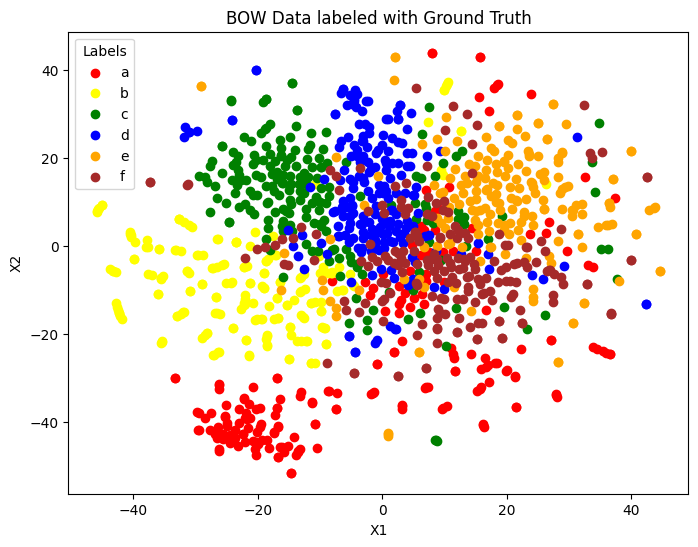

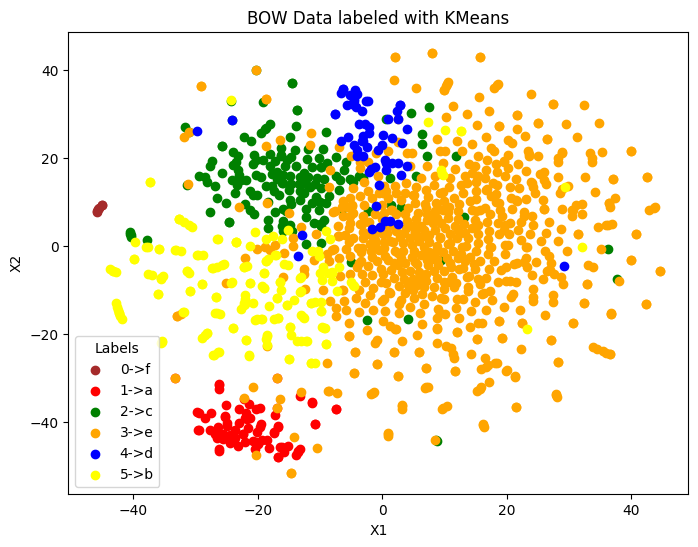

In [60]:
# Plot
plotData(data_BOW_tsne,data['Label'],data['Label'].unique())
plt.title('BOW Data labeled with Ground Truth')

plotData(data_BOW_tsne,kmeans_BOW_cluster_labels,np.unique(kmeans_BOW_cluster_labels),kmeans_BOW_cluster_to_majority_author)
plt.title('BOW Data labeled with KMeans')

In [61]:
preds=[]
for pred in kmeans_BOW_cluster_labels:
  preds.append(kmeans_BOW_cluster_to_majority_author[pred])
preds=pd.Series(preds)

In [62]:
preds

0       a
1       e
2       e
3       e
4       e
       ..
1195    e
1196    e
1197    e
1198    e
1199    e
Length: 1200, dtype: object

In [63]:
wrong=data[data['Label']!=preds]

In [64]:
for y in data['Label'].unique():
  top_collocations= find_top_collocations(wrong,y)
  print('Top 10 collocations of missclassified {}: {}'.format(y,top_collocations))

Top 10 collocations of missclassified a: [('6d', 'thirdborough'), ('administration', 'mango'), ('almond', 'sugar'), ('avail', 'borachio'), ('bermuda', 'labyrinth'), ('bonnyclabber', 'sour'), ('bookholder', 'prompter'), ('bordello', 'brothel'), ('buttermilk', 'bookholder'), ('chaotic', 'induce')]
Top 10 collocations of missclassified b: [('acquittal', 'instead'), ('convinced', 'themselves—all'), ('convincing', 'duty'), ('difficult', 'deal'), ('encourage', 'allow'), ('endeavour', 'clear'), ('fine', 'proposed'), ('hold', 'peace'), ('informing', 'convincing'), ('instead', 'informing')]
Top 10 collocations of missclassified c: [('foul', 'play'), ('la', 'mancha'), ('full', 'size'), ('quixote', 'la'), ('made', 'answer'), ('pup', 'would'), ('god', 'know')]
Top 10 collocations of missclassified d: [('mary', 'anne'), ('answer', 'question'), ('uriah', 'heep'), ('infinite', 'variety'), ('ma', 'r'), ('r', 'davy'), ('shall', 'forget'), ('long', 'ago'), ('early', 'morning'), ('ha', 'ha')]
Top 10 coll

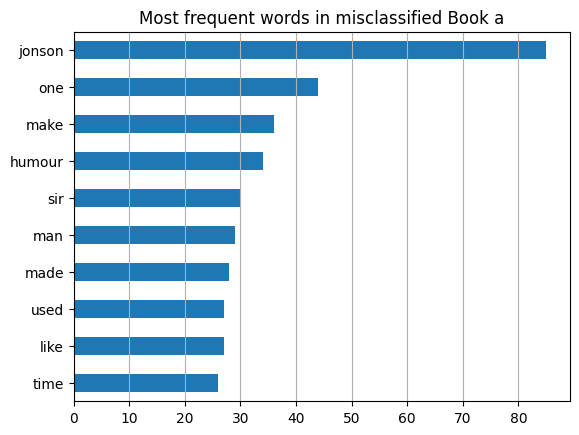

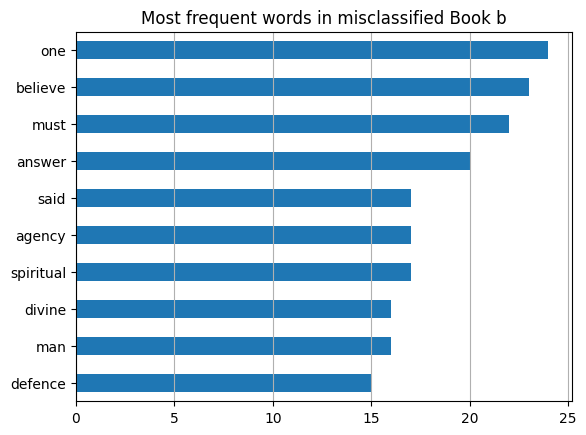

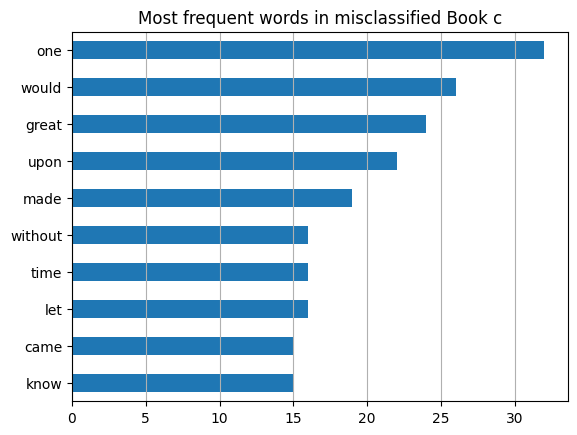

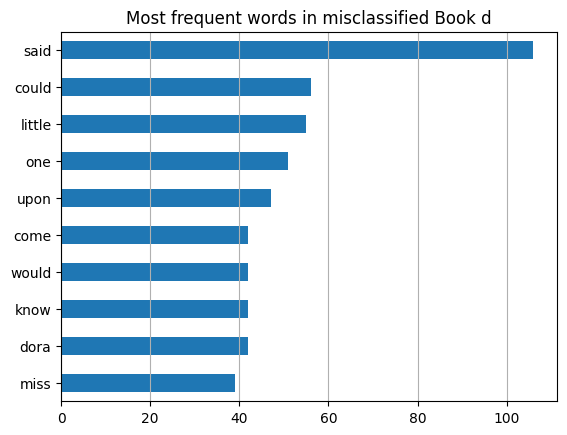

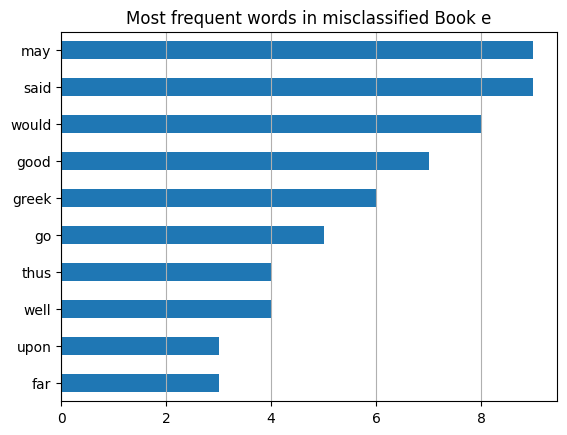

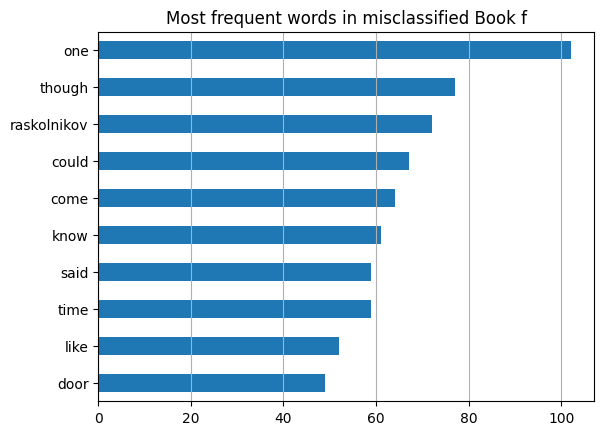

In [65]:
top= 10
for y in data['Label'].unique():
  corpus = wrong[wrong['Label']==y]['Partition_lemmatized']
  lst_tokens = get_tokens(corpus.str.cat(sep=" "))
  plt.figure()
  ax = plt.gca()
  ## unigrams
  dic_words_freq = nltk.FreqDist(lst_tokens)
  dtf_uni = pd.DataFrame(dic_words_freq.most_common(),columns=["Word","Freq"])
  dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(kind="barh", title="Most frequent words in misclassified Book {}".format(y), ax=ax,legend=False).grid(axis='x')
  ax.set(ylabel=None)

### **KMeans with TFIDF**

In [66]:
kmeans_tfidf_cluster_labels,kmeans_tfidf_cluster_centers= perform_kmeans(data_tfidf,6)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [67]:
# Evaluate metrics
kmeans_tfidf_metrics= evaluate_clusterer(data_tfidf,data['Label'],kmeans_tfidf_cluster_labels)
kmeans_tfidf_metrics

Silhouette  Kappa  Coherence
0    0.011742  0.658  -3.167784

In [68]:
# Check which majority authors the cluster labels correspond to
kmeans_tfidf_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],kmeans_tfidf_cluster_labels)
kmeans_tfidf_cluster_to_majority_author

{0: 'f', 1: 'e', 2: 'b', 3: 'c', 4: 'a', 5: 'd'}

In [69]:
# Transform data to 2D tsne to plot
data_tfidf_tsne= get_TSNE(data_tfidf)

Text(0.5, 1.0, 'tfidf Data labeled with KMeans')

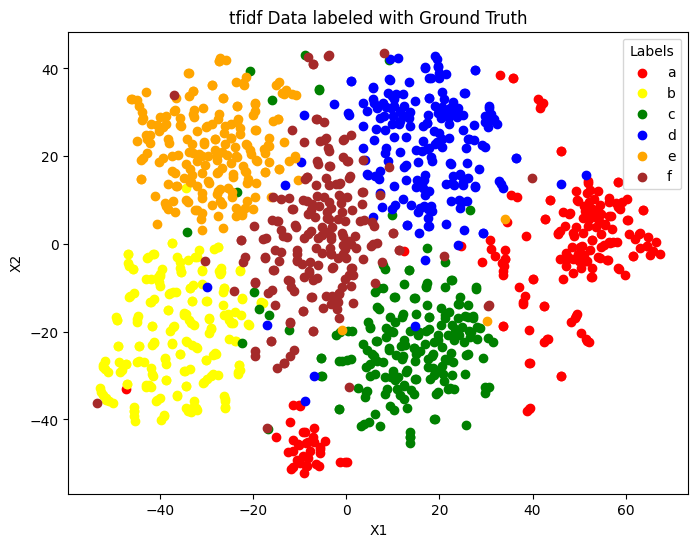

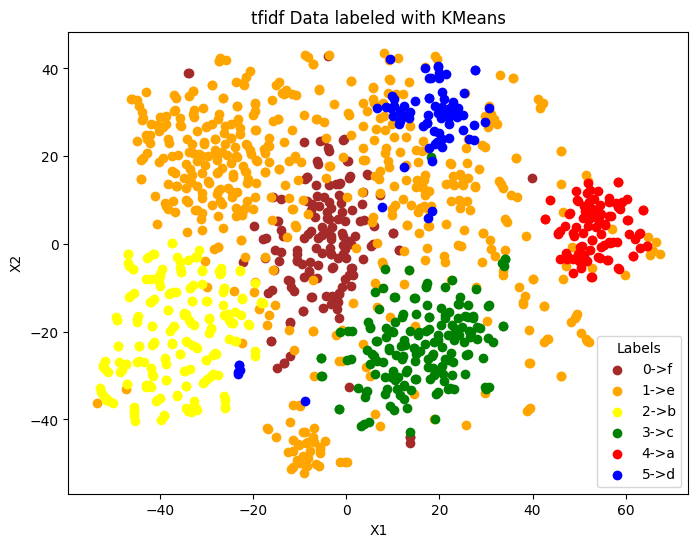

In [70]:
# Plot
plotData(data_tfidf_tsne,data['Label'],data['Label'].unique())
plt.title('tfidf Data labeled with Ground Truth')

plotData(data_tfidf_tsne,kmeans_tfidf_cluster_labels,np.unique(kmeans_tfidf_cluster_labels),kmeans_tfidf_cluster_to_majority_author)
plt.title('tfidf Data labeled with KMeans')

### **KMeans with doc2vec**

In [71]:
kmeans_d2v_cluster_labels,kmeans_d2v_cluster_centers= perform_kmeans(data_d2v,6)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [72]:
# Evaluate metrics
kmeans_d2v_metrics= evaluate_clusterer(data_d2v,data['Label'],kmeans_d2v_cluster_labels)
kmeans_d2v_metrics

Silhouette  Kappa  Coherence
0    0.062232  0.663   -3.84797

In [73]:
# Check which majority authors the cluster labels correspond to
kmeans_d2v_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],kmeans_d2v_cluster_labels)
kmeans_d2v_cluster_to_majority_author

{0: 'f', 1: 'd', 2: 'b', 3: 'c', 4: 'a', 5: 'e'}

In [74]:
# Transform data to 2D tsne to plot
data_d2v_tsne= get_TSNE(data_d2v)

Text(0.5, 1.0, 'd2v Data labeled with KMeans')

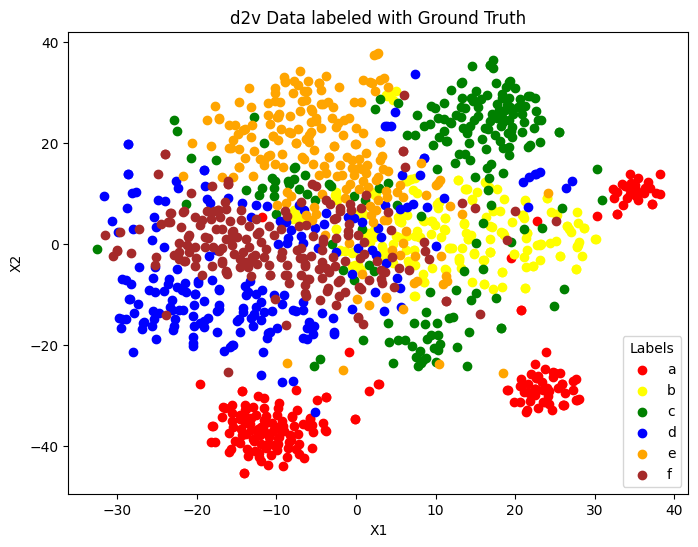

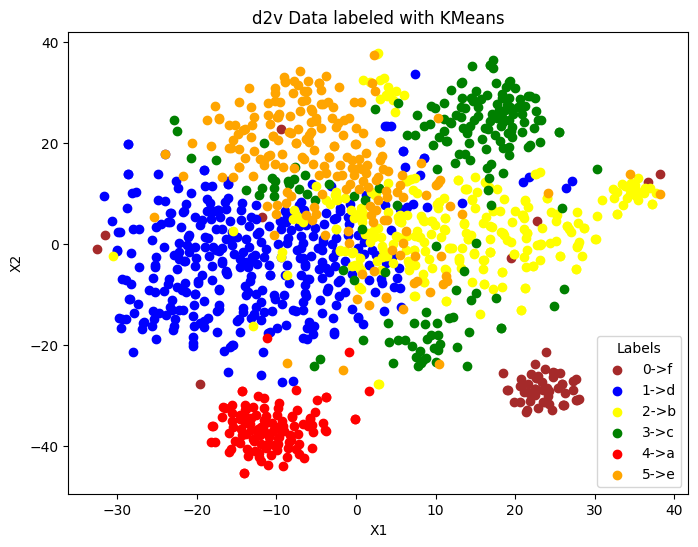

In [75]:
# Plot
plotData(data_d2v_tsne,data['Label'],data['Label'].unique())
plt.title('d2v Data labeled with Ground Truth')

plotData(data_d2v_tsne,kmeans_d2v_cluster_labels,np.unique(kmeans_d2v_cluster_labels),kmeans_d2v_cluster_to_majority_author)
plt.title('d2v Data labeled with KMeans')

### **KMeans with LDA**

In [76]:
kmeans_lda_cluster_labels,kmeans_lda_cluster_centers= perform_kmeans(data_lda,6)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [77]:
# Evaluate metrics
kmeans_lda_metrics= evaluate_clusterer(data_lda,data['Label'],kmeans_lda_cluster_labels)
kmeans_lda_metrics

Silhouette  Kappa  Coherence
0    0.572699  0.354  -4.313056

In [78]:
# Check which majority authors the cluster labels correspond to
kmeans_lda_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],kmeans_lda_cluster_labels)
kmeans_lda_cluster_to_majority_author

{0: 'c', 1: 'b', 2: 'a', 3: 'e', 4: 'd', 5: 'f'}

In [79]:
# Transform data to 2D tsne to plot
data_lda_tsne= get_TSNE(data_lda)

Text(0.5, 1.0, 'lda Data labeled with KMeans')

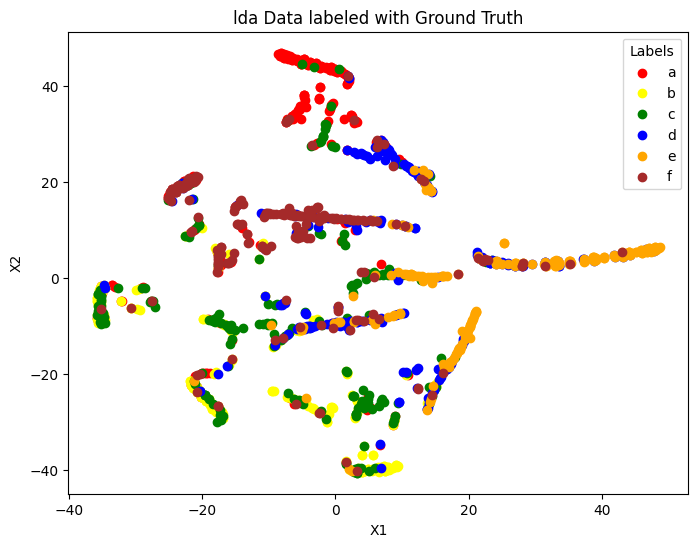

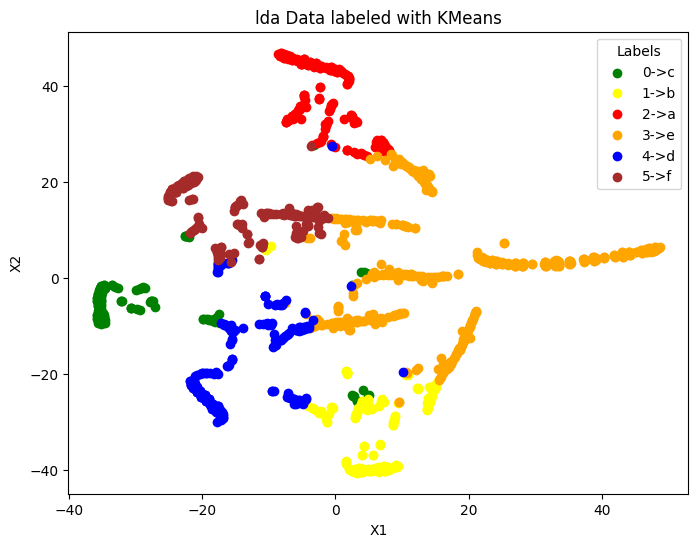

In [80]:
# Plot
plotData(data_lda_tsne,data['Label'],data['Label'].unique())
plt.title('lda Data labeled with Ground Truth')

plotData(data_lda_tsne,kmeans_lda_cluster_labels,np.unique(kmeans_lda_cluster_labels),kmeans_lda_cluster_to_majority_author)
plt.title('lda Data labeled with KMeans')

### **KMeans Metrics**

In [81]:
kmeans_metrics = pd.concat([kmeans_BOW_metrics,kmeans_tfidf_metrics,kmeans_d2v_metrics,kmeans_lda_metrics]).reset_index(drop=True)
kmeans_metrics.index=['BOW','TFIDF','doc2vec','LDA']
kmeans_metrics

Silhouette  Kappa  Coherence
BOW        0.015523  0.444  -2.726908
TFIDF      0.011742  0.658  -3.167784
doc2vec    0.062232  0.663  -3.847970
LDA        0.572699  0.354  -4.313056

## **Hierarchical Clustering**

### **Hierarchical Clustering with BOW**

In [82]:
def perform_hc(data, n_clusters=6):
  hc = AgglomerativeClustering(n_clusters = 6, metric = 'euclidean', linkage = 'ward')
  cluster_labels = hc.fit_predict(data)
  return cluster_labels

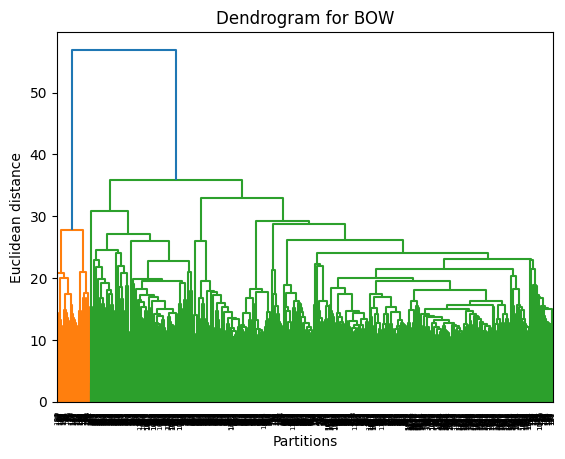

In [83]:
dendrogrm = sch.dendrogram(sch.linkage(data_BOW, method = 'ward'))
plt.title('Dendrogram for BOW')
plt.xlabel('Partitions')
plt.ylabel('Euclidean distance')
plt.show()

In [84]:
hc_BOW_cluster_labels= perform_hc(data_BOW,6)

In [85]:
# Evaluate metrics
hc_BOW_metrics= evaluate_clusterer(data_BOW,data['Label'],hc_BOW_cluster_labels)
hc_BOW_metrics

Silhouette  Kappa  Coherence
0    0.011886  0.427   -2.89684

In [86]:
# Check which majority authors the cluster labels correspond to
hc_BOW_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],hc_BOW_cluster_labels)
hc_BOW_cluster_to_majority_author

{0: 'f', 1: 'a', 2: 'b', 3: 'd', 4: 'e', 5: 'c'}

Text(0.5, 1.0, 'BOW Data labeled with Hierarchical Clustering')

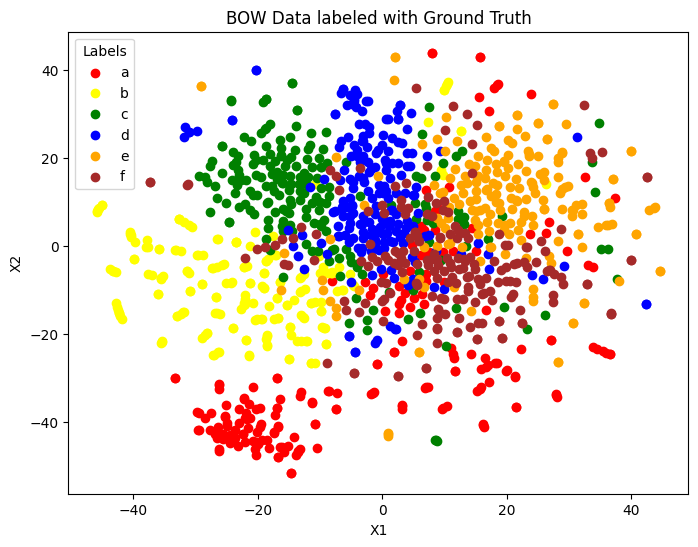

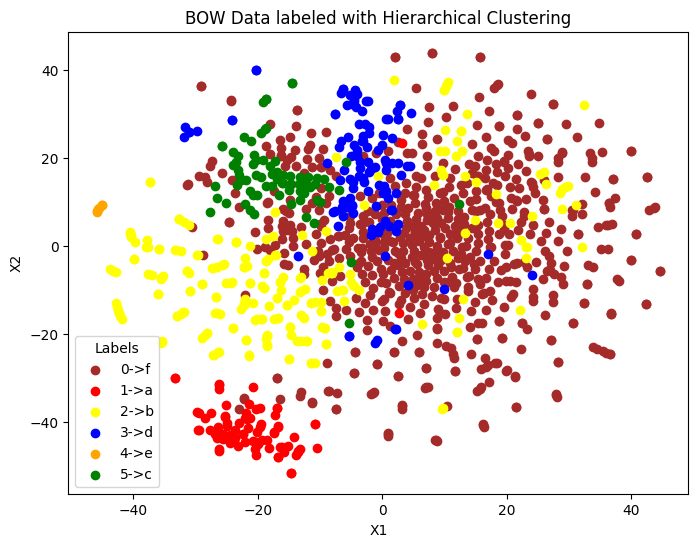

In [87]:
# Plot
plotData(data_BOW_tsne,data['Label'],data['Label'].unique())
plt.title('BOW Data labeled with Ground Truth')

plotData(data_BOW_tsne,hc_BOW_cluster_labels,np.unique(hc_BOW_cluster_labels),hc_BOW_cluster_to_majority_author)
plt.title('BOW Data labeled with Hierarchical Clustering')

### **Hierarchical Clustering with tfidf**

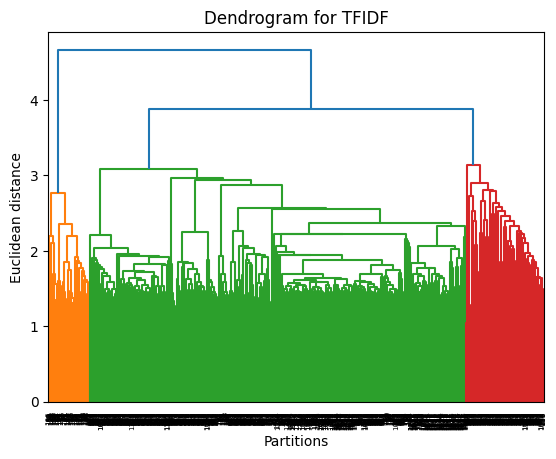

In [88]:
dendrogrm = sch.dendrogram(sch.linkage(data_tfidf, method = 'ward'))
plt.title('Dendrogram for TFIDF')
plt.xlabel('Partitions')
plt.ylabel('Euclidean distance')
plt.show()

In [89]:
hc_tfidf_cluster_labels= perform_hc(data_tfidf,6)

In [90]:
# Evaluate metrics
hc_tfidf_metrics= evaluate_clusterer(data_tfidf,data['Label'],hc_tfidf_cluster_labels)
hc_tfidf_metrics

Silhouette  Kappa  Coherence
0    0.009144   0.46   -2.80716

In [91]:
# Check which majority authors the cluster labels correspond to
hc_tfidf_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],hc_tfidf_cluster_labels)
hc_tfidf_cluster_to_majority_author

{0: 'f', 1: 'a', 2: 'b', 3: 'c', 4: 'e', 5: 'd'}

Text(0.5, 1.0, 'tfidf Data labeled with Hierarchical Clustering')

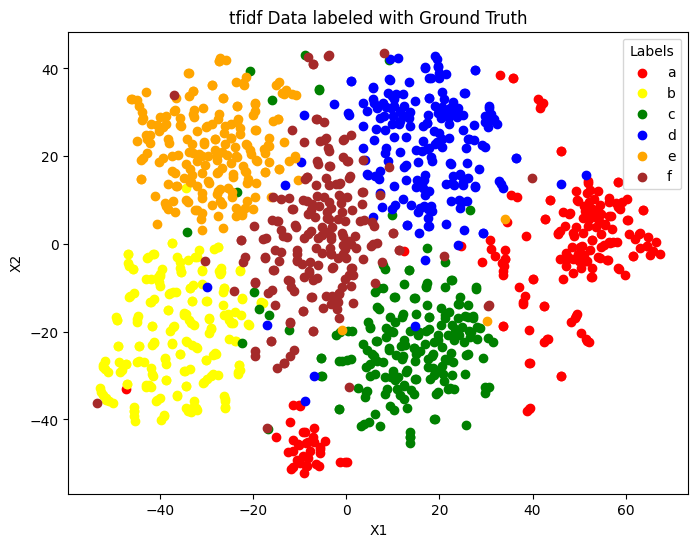

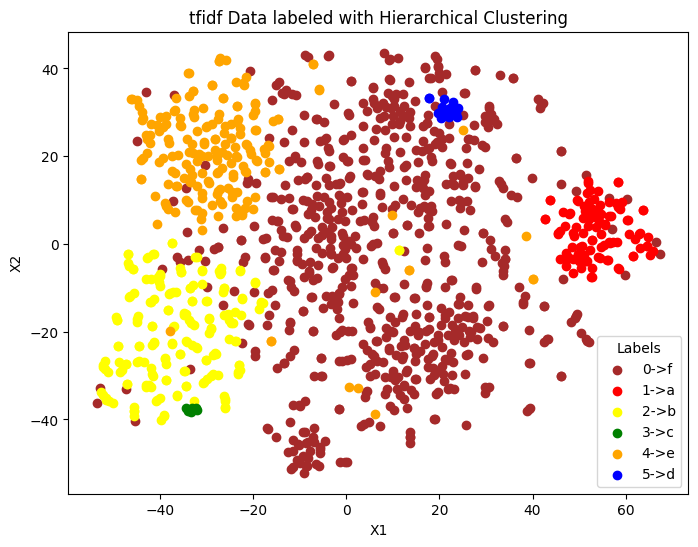

In [92]:
# Plot
plotData(data_tfidf_tsne,data['Label'],data['Label'].unique())
plt.title('tfidf Data labeled with Ground Truth')

plotData(data_tfidf_tsne,hc_tfidf_cluster_labels,np.unique(hc_tfidf_cluster_labels),hc_tfidf_cluster_to_majority_author)
plt.title('tfidf Data labeled with Hierarchical Clustering')

### **Hierarchical Clustering with doc2vec**

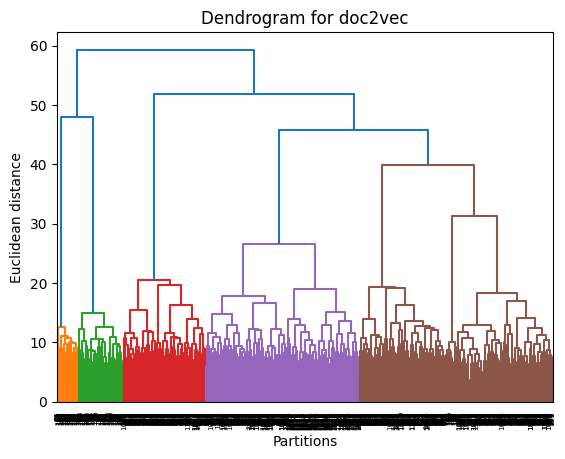

In [93]:
dendrogrm = sch.dendrogram(sch.linkage(data_d2v, method = 'ward'))
plt.title('Dendrogram for doc2vec')
plt.xlabel('Partitions')
plt.ylabel('Euclidean distance')
plt.show()

In [94]:
hc_d2v_cluster_labels= perform_hc(data_d2v,6)

In [95]:
# Evaluate metrics
hc_d2v_metrics= evaluate_clusterer(data_d2v,data['Label'],hc_d2v_cluster_labels)
hc_d2v_metrics

Silhouette  Kappa  Coherence
0     0.05133  0.616  -3.605358

In [96]:
# Check which majority authors the cluster labels correspond to
hc_d2v_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],hc_d2v_cluster_labels)
hc_d2v_cluster_to_majority_author

{0: 'b', 1: 'd', 2: 'c', 3: 'f', 4: 'a', 5: 'e'}

Text(0.5, 1.0, 'd2v Data labeled with Hierarchical Clustering')

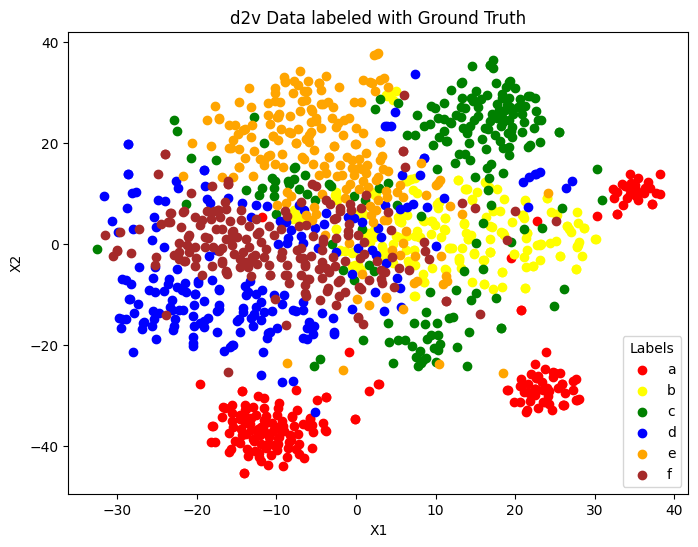

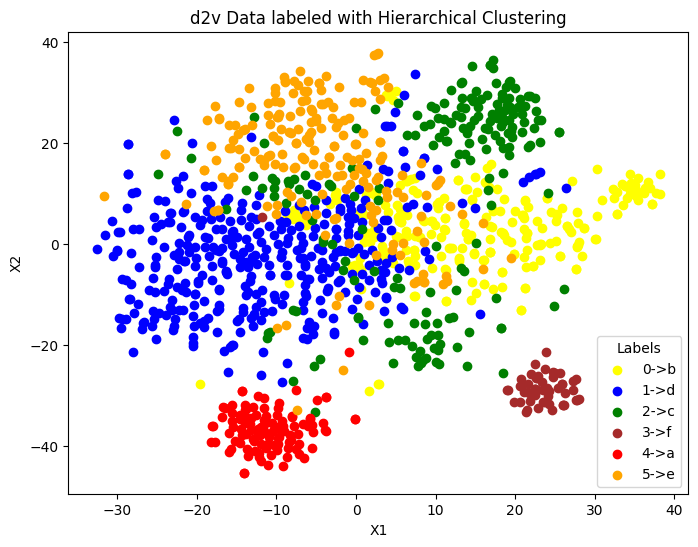

In [97]:
# Plot
plotData(data_d2v_tsne,data['Label'],data['Label'].unique())
plt.title('d2v Data labeled with Ground Truth')

plotData(data_d2v_tsne,hc_d2v_cluster_labels,np.unique(hc_d2v_cluster_labels),hc_d2v_cluster_to_majority_author)
plt.title('d2v Data labeled with Hierarchical Clustering')

### **Hierarchical Clustering with lda**

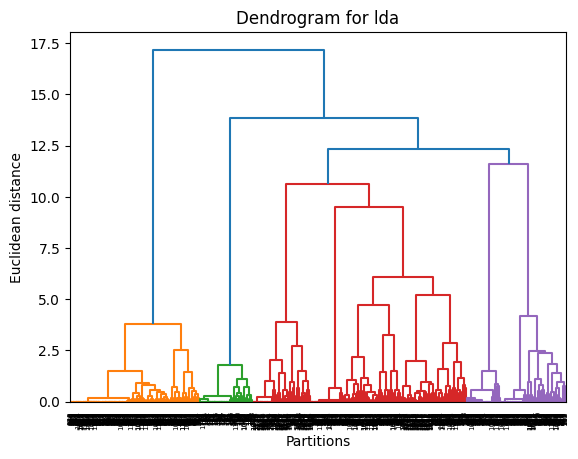

In [98]:
dendrogrm = sch.dendrogram(sch.linkage(data_lda, method = 'ward'))
plt.title('Dendrogram for lda')
plt.xlabel('Partitions')
plt.ylabel('Euclidean distance')
plt.show()

In [99]:
hc_lda_cluster_labels= perform_hc(data_lda,6)

In [100]:
# Evaluate metrics
hc_lda_metrics= evaluate_clusterer(data_lda,data['Label'],hc_lda_cluster_labels)
hc_lda_metrics

Silhouette  Kappa  Coherence
0    0.428638  0.364   -4.29781

In [101]:
# Check which majority authors the cluster labels correspond to
hc_lda_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],hc_lda_cluster_labels)
hc_lda_cluster_to_majority_author

{0: 'd', 1: 'b', 2: 'f', 3: 'e', 4: 'c', 5: 'a'}

Text(0.5, 1.0, 'lda Data labeled with Hierarchical Clustering')

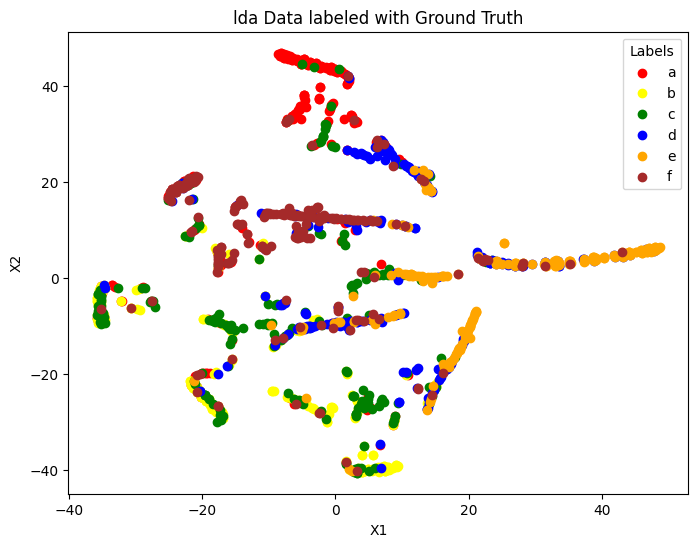

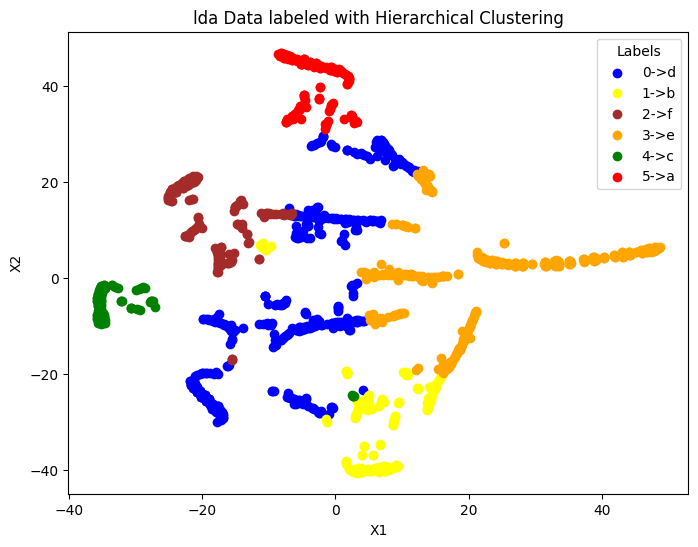

In [102]:
# Plot
plotData(data_lda_tsne,data['Label'],data['Label'].unique())
plt.title('lda Data labeled with Ground Truth')

plotData(data_lda_tsne,hc_lda_cluster_labels,np.unique(hc_lda_cluster_labels),hc_lda_cluster_to_majority_author)
plt.title('lda Data labeled with Hierarchical Clustering')

### **HC Metrics**

In [103]:
hc_metrics = pd.concat([hc_BOW_metrics,hc_tfidf_metrics,hc_d2v_metrics,hc_lda_metrics]).reset_index(drop=True)
hc_metrics.index=['BOW','TFIDF','doc2vec','LDA']
hc_metrics

Silhouette  Kappa  Coherence
BOW        0.011886  0.427  -2.896840
TFIDF      0.009144  0.460  -2.807160
doc2vec    0.051330  0.616  -3.605358
LDA        0.428638  0.364  -4.297810

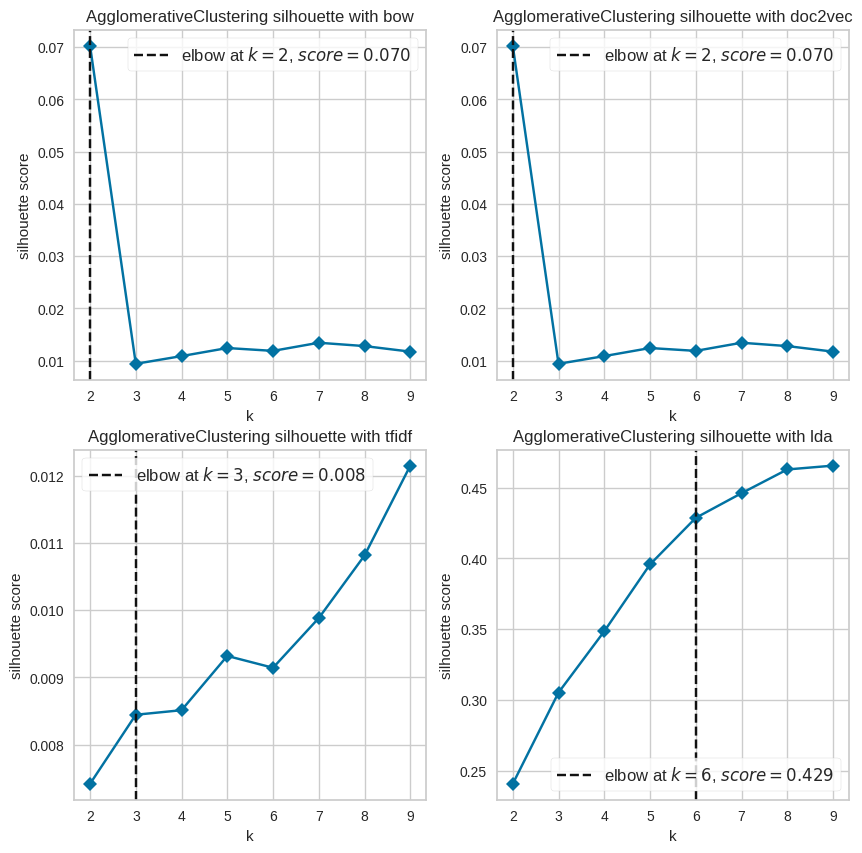

In [105]:
text_embedding = {
    'bow' : data_BOW,
    'tfidf' : data_tfidf,
    'doc2vec' : data_BOW,
    'lda' : data_lda
}
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
# from yellowbrick.features import FeatureImportances
# from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC
# from sklearn.linear_model import LogisticRegression

x_size , y_size =2,2
fig, axes = plt.subplots(2, 2,figsize=(10,10))

model = AgglomerativeClustering()

visualgrid = []
for i in range(len(text_embedding.keys())):
    ax = axes[i % x_size][i // y_size]
    ax.set_title(text_embedding.keys())
    visualgrid.append(KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=False, ax=axes[i%x_size][i//y_size], title = type(model).__name__ + ' silhouette with ' + list(text_embedding.keys())[i]))

for vis,key in zip(visualgrid,text_embedding.keys()):
    vis.fit(text_embedding[key])
    vis.ax.set_title(key)
    vis.finalize()

plt.show()

## **EM Clustering**

###**EM with BOW**

In [106]:
def perform_em(data, n_clusters=6):
    em = GaussianMixture(n_components=6, random_state=42)
    cluster_labels = em.fit_predict(data)
    return cluster_labels

In [107]:
# Get PCA reduced data since EM uses a lot of memory and crashes due to no more RAM
# Perform PCA (w/o limits on n_components)
pca = PCA(random_state=42)
data_BOW_pca = pca.fit_transform(data_BOW)

# Convert back to DataFrame for readability
data_BOW_pca = pd.DataFrame(data=data_BOW_pca)

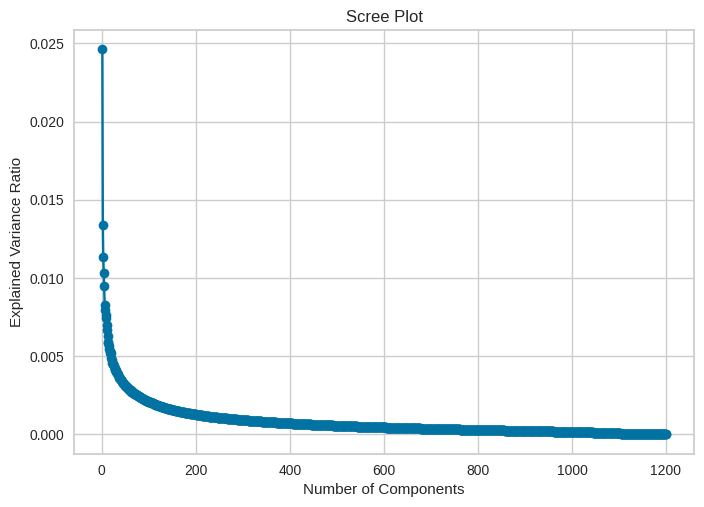

In [108]:
# Plot the explained variance ratio for each principal component.
# Look for the "elbow" point in the plot, where the explained variance starts to level off.
# Select the number of components corresponding to the "elbow" point.
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

In [109]:
# Keep only the first 400 components since they explain the majority of the variance in the data. Components after the elbow explain relatively little additional variance
data_BOW_pca = data_BOW_pca.iloc[:,:400]

In [110]:
em_BOW_cluster_labels= perform_em(data_BOW_pca,6)

In [111]:
# Evaluate metrics
em_BOW_metrics= evaluate_clusterer(data_BOW_pca,data['Label'],em_BOW_cluster_labels)
em_BOW_metrics

Silhouette  Kappa  Coherence
0    0.008633  0.261    -2.6431

In [112]:
# Check which majority authors the cluster labels correspond to
em_BOW_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],em_BOW_cluster_labels)
em_BOW_cluster_to_majority_author

{0: 'c', 1: 'b', 2: 'a', 3: 'e', 4: 'd', 5: 'f'}

In [113]:
# Transform data to 2D tsne to plot
data_BOW_pca_tsne= get_TSNE(data_BOW_pca)

Text(0.5, 1.0, 'BOW Data labeled with EM')

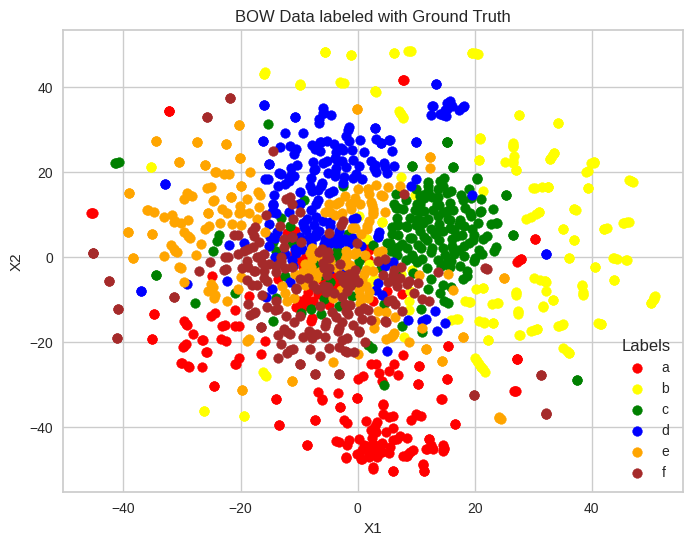

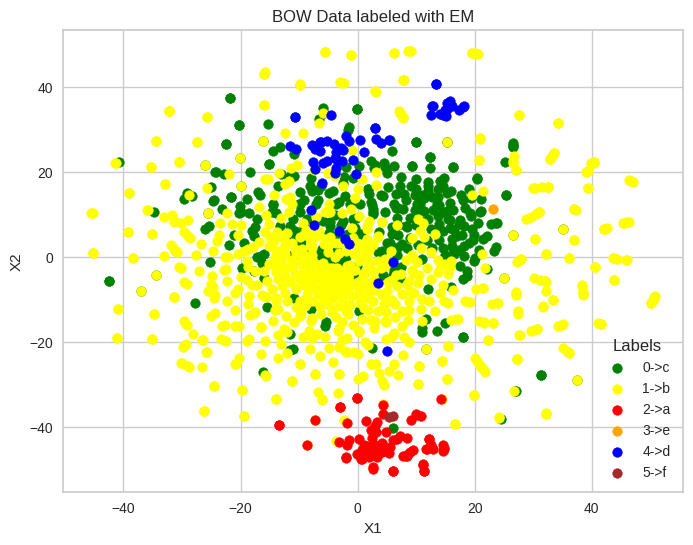

In [114]:
# Plot
plotData(data_BOW_pca_tsne,data['Label'],data['Label'].unique())
plt.title('BOW Data labeled with Ground Truth')

plotData(data_BOW_pca_tsne,em_BOW_cluster_labels,np.unique(em_BOW_cluster_labels),em_BOW_cluster_to_majority_author)
plt.title('BOW Data labeled with EM')

###**EM with tfidf**

In [115]:
# Get PCA reduced data since EM uses a lot of memory and crashes due to no more RAM
# Perform PCA (w/o limits on n_components)
pca = PCA(random_state=42)
data_tfidf_pca = pca.fit_transform(data_tfidf)

# Convert back to DataFrame for readability
data_tfidf_pca = pd.DataFrame(data=data_tfidf_pca)

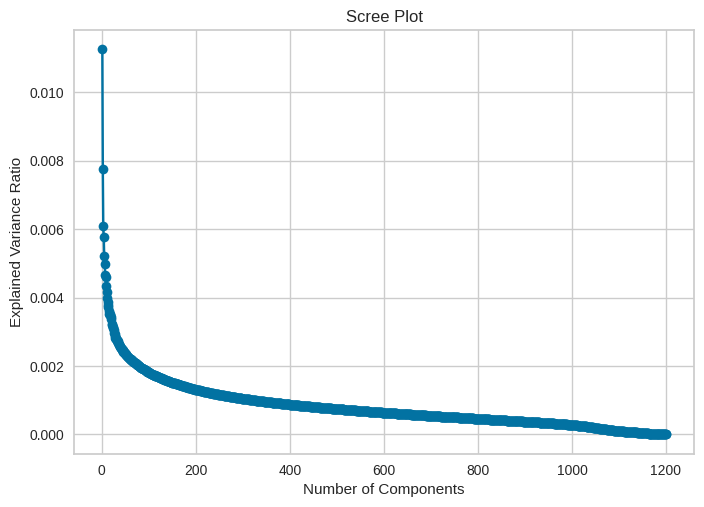

In [116]:
# Plot the explained variance ratio for each principal component.
# Look for the "elbow" point in the plot, where the explained variance starts to level off.
# Select the number of components corresponding to the "elbow" point.
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

In [117]:
# Keep only the first 400 components since they explain the majority of the variance in the data. Components after the elbow explain relatively little additional variance
data_tfidf_pca = data_tfidf_pca.iloc[:,:400]

In [118]:
em_tfidf_cluster_labels= perform_em(data_tfidf_pca,6)

In [119]:
# Evaluate metrics
em_tfidf_metrics= evaluate_clusterer(data_tfidf_pca,data['Label'],em_tfidf_cluster_labels)
em_tfidf_metrics

Silhouette  Kappa  Coherence
0    0.006366   0.35  -3.329786

In [120]:
# Check which majority authors the cluster labels correspond to
em_tfidf_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],em_tfidf_cluster_labels)
em_tfidf_cluster_to_majority_author

{0: 'b', 1: 'e', 2: 'c', 3: 'd', 4: 'a', 5: 'f'}

In [121]:
# Transform data to 2D tsne to plot
data_tfidf_pca_tsne= get_TSNE(data_tfidf_pca)

Text(0.5, 1.0, 'tfidf Data labeled with EM')

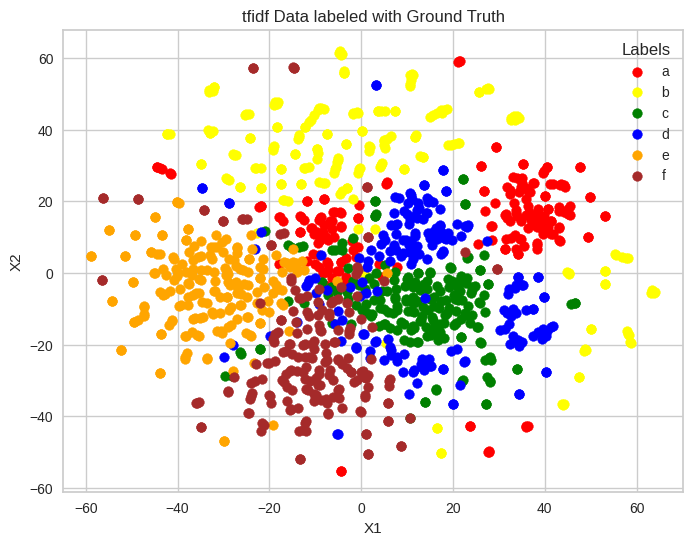

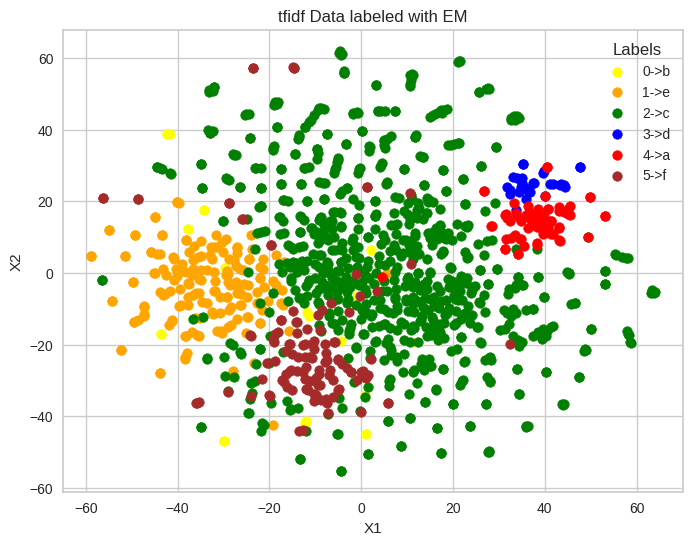

In [122]:
# Plot
plotData(data_tfidf_pca_tsne,data['Label'],data['Label'].unique())
plt.title('tfidf Data labeled with Ground Truth')

plotData(data_tfidf_pca_tsne,em_tfidf_cluster_labels,np.unique(em_tfidf_cluster_labels),em_tfidf_cluster_to_majority_author)
plt.title('tfidf Data labeled with EM')

###**EM with doc2vec**

In [123]:
em_d2v_cluster_labels= perform_em(data_d2v,6)

In [124]:
# Evaluate metrics
em_d2v_metrics= evaluate_clusterer(data_d2v,data['Label'],em_d2v_cluster_labels)
em_d2v_metrics

Silhouette  Kappa  Coherence
0    0.063533  0.632  -4.047199

In [125]:
# Check which majority authors the cluster labels correspond to
em_d2v_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],em_d2v_cluster_labels)
em_d2v_cluster_to_majority_author

{0: 'd', 1: 'a', 2: 'e', 3: 'c', 4: 'b', 5: 'f'}

Text(0.5, 1.0, 'd2v Data labeled with EM')

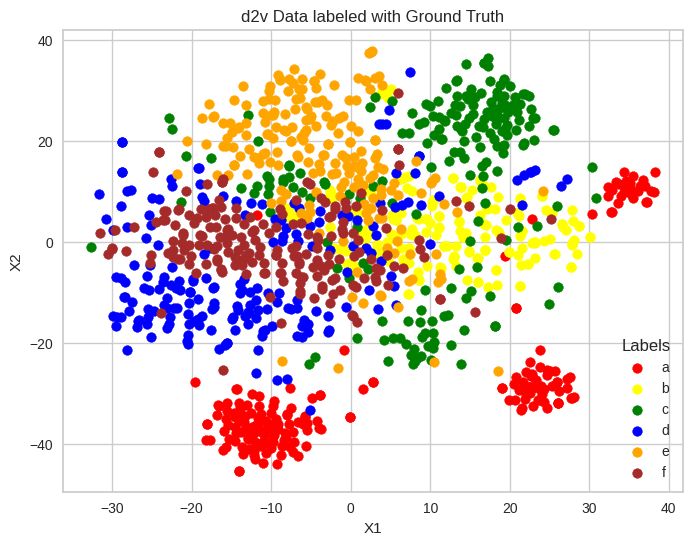

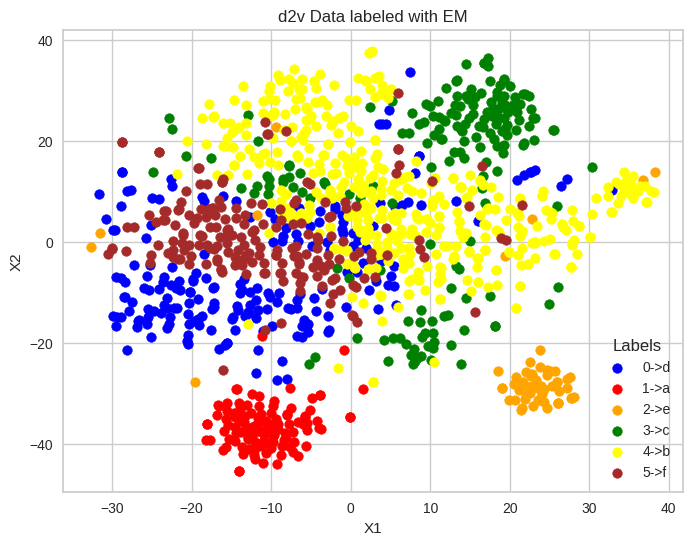

In [126]:
# Plot
plotData(data_d2v_tsne,data['Label'],data['Label'].unique())
plt.title('d2v Data labeled with Ground Truth')

plotData(data_d2v_tsne,em_d2v_cluster_labels,np.unique(em_d2v_cluster_labels),em_d2v_cluster_to_majority_author)
plt.title('d2v Data labeled with EM')

###**EM with lda**

In [127]:
em_lda_cluster_labels= perform_em(data_lda,6)

In [128]:
# Evaluate metrics
em_lda_metrics= evaluate_clusterer(data_lda,data['Label'],em_lda_cluster_labels)
em_lda_metrics

Silhouette  Kappa  Coherence
0    0.063532  0.265  -4.425433

In [129]:
# Check which majority authors the cluster labels correspond to
em_lda_cluster_to_majority_author= get_cluster_to_majority_author(data['Label'],em_lda_cluster_labels)
em_lda_cluster_to_majority_author

{0: 'e', 1: 'c', 2: 'a', 3: 'b', 4: 'f', 5: 'd'}

Text(0.5, 1.0, 'lda Data labeled with EM')

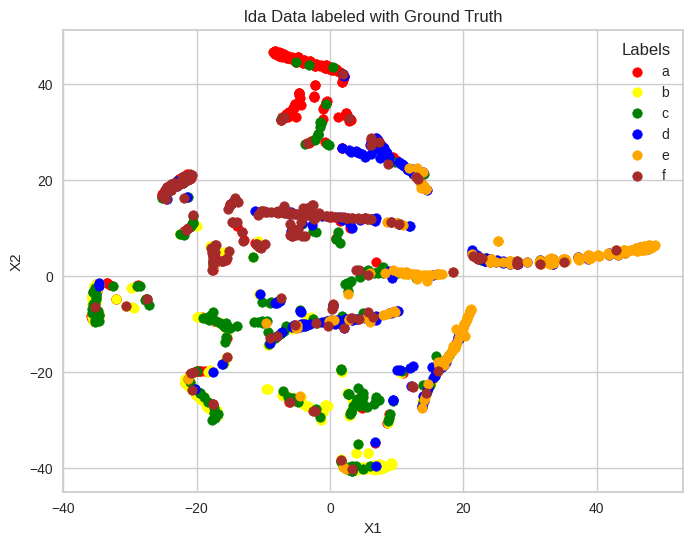

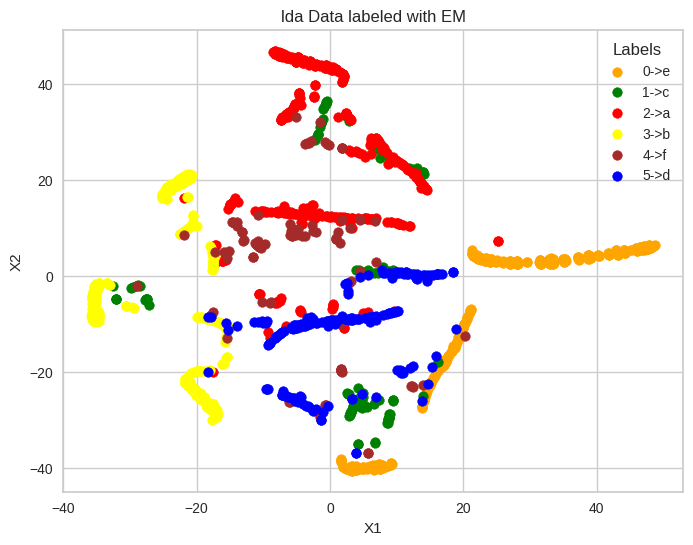

In [130]:
# Plot
plotData(data_lda_tsne,data['Label'],data['Label'].unique())
plt.title('lda Data labeled with Ground Truth')

plotData(data_lda_tsne,em_lda_cluster_labels,np.unique(em_lda_cluster_labels),em_lda_cluster_to_majority_author)
plt.title('lda Data labeled with EM')

### **EM Metrics**

In [131]:
em_metrics = pd.concat([em_BOW_metrics,em_tfidf_metrics,em_d2v_metrics,em_lda_metrics]).reset_index(drop=True)
em_metrics.index=['BOW','TFIDF','doc2vec','LDA']
em_metrics

Silhouette  Kappa  Coherence
BOW        0.008633  0.261  -2.643100
TFIDF      0.006366  0.350  -3.329786
doc2vec    0.063533  0.632  -4.047199
LDA        0.063532  0.265  -4.425433